# ERA5 - download data
From this [website](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels?tab=overview). Follow their instructions on how to [install their CDS API](https://cds.climate.copernicus.eu/api-how-to) and then copy/paste the Python "MARSREQUEST" code into this notebook to download the relevant variables for your budget in netcdf format.

In [1]:
import xarray as xr
import numpy as np

sw_june = xr.open_dataset('2024June_sw.nc', chunks={})
sw_june

<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 81, latitude: 41, time: 720)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-06-01 ... 2024-06-30T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 19MB dask.array<chunksize=(720, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-12 18:03:56 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
(sw_june.ssr/(60*60)).mean(['longitude', 'latitude', 'time']).values

array(246.68704691)

In [13]:
import xarray as xr

ds = xr.open_dataset('tot_cloud_cover.nc')
tcc = ds.tcc.drop_vars(('number', 'expver')).resample(valid_time='D').mean('valid_time')

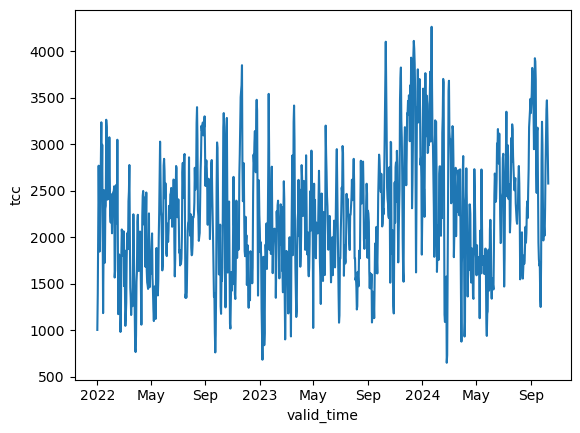

In [14]:
tcc.sum(['latitude', 'longitude']).plot()

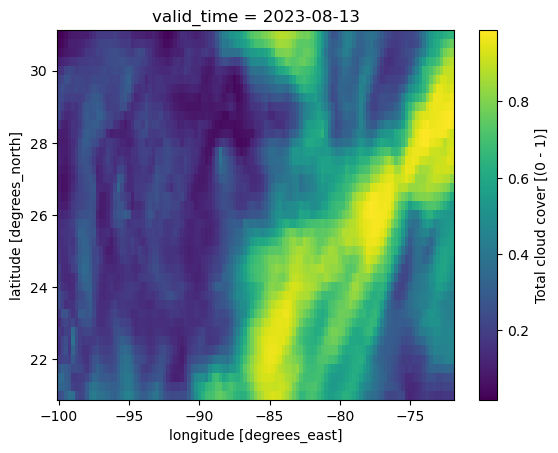

In [16]:
tcc.sel(valid_time='2023-08-13', method='nearest').plot()

In [17]:
#upload 2022-2024 total cloud cover variable so you can delete in local dir
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_tcc = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/tcc_22-24.zarr')
ds.to_zarr(gcsmap_tcc, mode='w')

In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            'surface_latent_heat_flux', 'surface_net_thermal_radiation', 'surface_sensible_heat_flux',
        ],
        'year': '2024',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            31, -100, 21,
            -72,
        ],
    },
    '2024-surfterms.nc')

2024-07-11 20:38:56,684 INFO Welcome to the CDS
2024-07-11 20:38:56,685 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-11 20:38:56,851 INFO Request is queued
2024-07-11 20:40:51,510 INFO Request is running
2024-07-11 21:03:21,970 INFO Request is completed
2024-07-11 21:03:21,971 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data1/adaptor.mars.internal-1720731763.522394-14431-2-c87f3fff-5478-4e0c-99b4-7a053c06bf85.nc to 2024-surfterms.nc (231.6M)
2024-07-11 21:03:52,666 INFO Download rate 7.5M/s  


Result(content_length=242863308,content_type=application/x-netcdf,location=https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data1/adaptor.mars.internal-1720731763.522394-14431-2-c87f3fff-5478-4e0c-99b4-7a053c06bf85.nc)

In [2]:
import xarray as xr
import json
import gcsfs
import numpy as np

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

rest_terms2024 = xr.open_dataset('2024-surfterms.nc', chunks={})

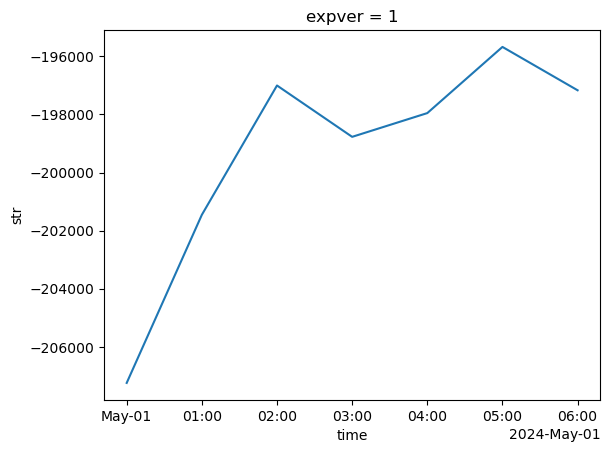

In [21]:
rest_terms2024.str.sel(time=slice('2024-05-01','2024-05-02')).isel(expver=0).mean(['latitude', 'longitude']).plot()

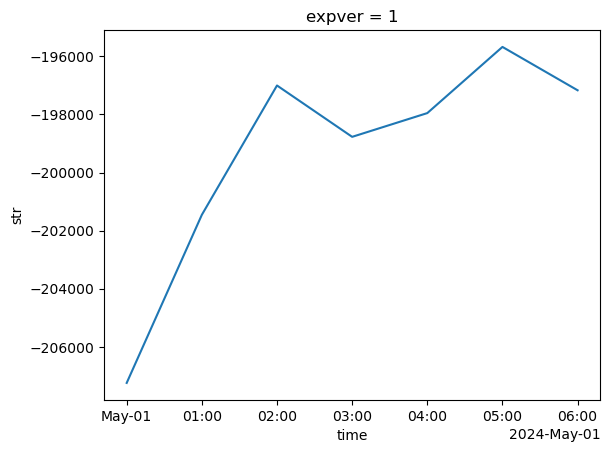

In [44]:
rest_terms2024.str.sel(time=slice('2024-05-01T00:00:00',
                                  '2024-05-01T06:00:00')).isel(expver=0).mean(['latitude', 'longitude']).plot()

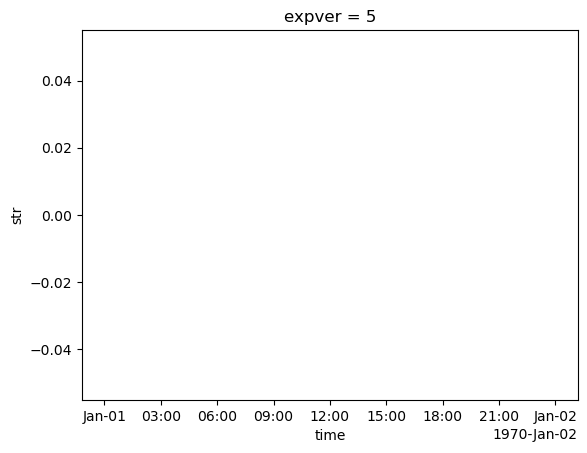

In [45]:
rest_terms2024.str.sel(time=slice('2024-05-01T00:00:00',
                                  '2024-05-01T06:00:00')).isel(expver=1).mean(['latitude', 'longitude']).plot()

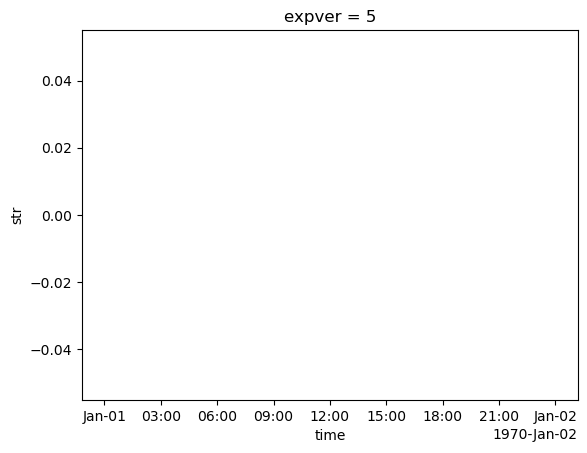

In [46]:
rest_terms2024.str.sel(time=slice('2024-05-01T00:00:00',
                                  '2024-05-01T06:00:00')).isel(expver=1).mean(['latitude', 'longitude']).plot()

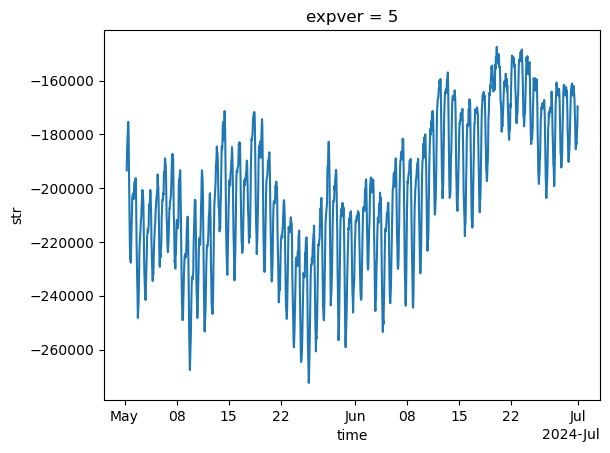

In [47]:
rest_terms2024.str.sel(time=slice('2024-05-01T06:00:00',
                                  '2024-06-30')).isel(expver=1).mean(['latitude', 'longitude']).plot()

In [50]:
jan_may01 = rest_terms2024.sel(time=slice(None, '2024-05-01T06:00:00')).isel(expver=0)
may_june = rest_terms2024.sel(time=slice('2024-05-01T07:00:00', None)).isel(expver=1)

In [52]:
merged_rest = xr.merge([jan_may01.drop_vars('expver'), may_june.drop_vars('expver')])

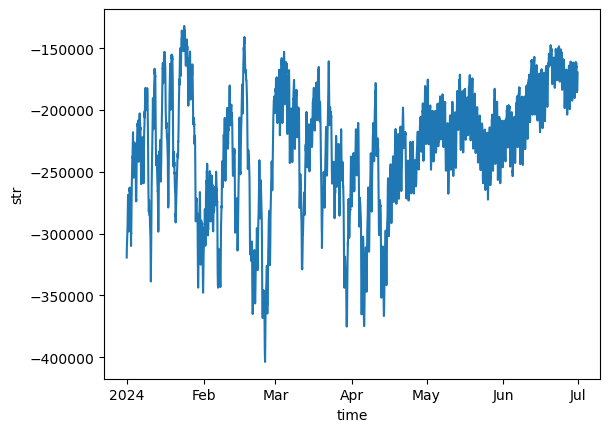

In [54]:
merged_rest.str.mean(['latitude', 'longitude']).plot()

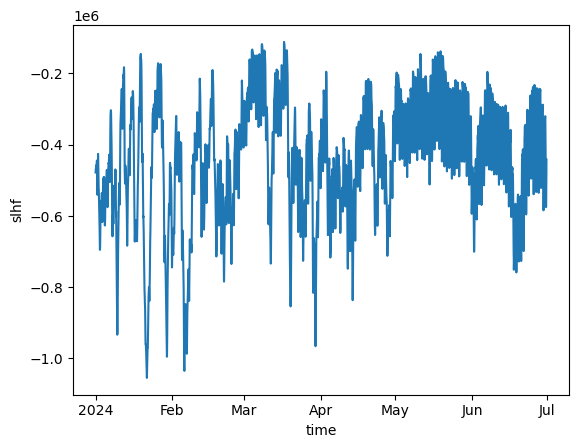

In [56]:
merged_rest.slhf.mean(['latitude', 'longitude']).plot()

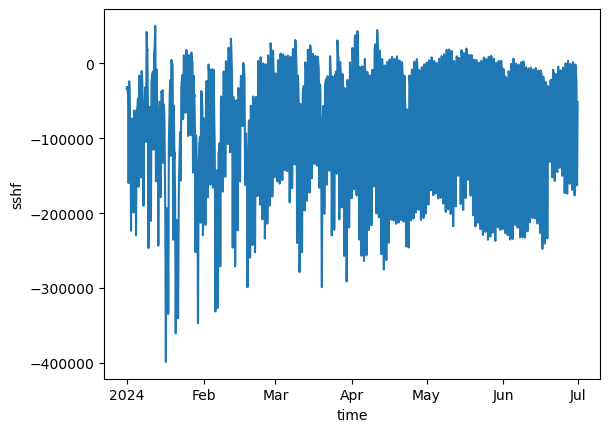

In [55]:
merged_rest.sshf.mean(['latitude', 'longitude']).plot()

In [57]:
#upload merged 2024 reset of surf terms
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_rest = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-rest_up2june.zarr')
merged_rest.to_zarr(gcsmap_rest, mode='w')

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

era24_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-sst.zarr'))
era24_ssr = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr.zarr'))
sw_sst_june2024 = xr.open_dataset('2024Junesw_sst.nc', chunks={})

In [5]:
sw_sst_sliced = sw_sst_june2024.sel(longitude=slice(-100,-80))

In [2]:
era24_sst.coords

Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00

In [3]:
era24_ssr.coords

Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00

In [6]:
sw_sst_sliced.coords

Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-06-01 ... 2024-06-30T23:00:00

In [8]:
merged_ssr = xr.merge([era24_ssr, sw_sst_sliced.ssr])
merged_sst = xr.merge([era24_sst, sw_sst_sliced.sst])

In [9]:
merged_ssr.coords

Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 35kB 2024-01-01 ... 2024-06-30T23:00:00

In [10]:
#upload merged 2024 sst/sw
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ssr = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr_up2june.zarr')
merged_ssr.to_zarr(gcsmap_ssr, mode='w')

In [11]:
gcsmap_sst = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-sst_up2june.zarr')
merged_sst.to_zarr(gcsmap_sst, mode='w')

In [15]:
test = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr_up2june.zarr'))
test

<xarray.Dataset> Size: 116MB
Dimensions:    (latitude: 41, longitude: 81, time: 4368)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 35kB 2024-01-01 ... 2024-06-30T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 116MB dask.array<chunksize=(4368, 41, 81), meta=np.ndarray>
Attributes:
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux
    units:          J m**-2

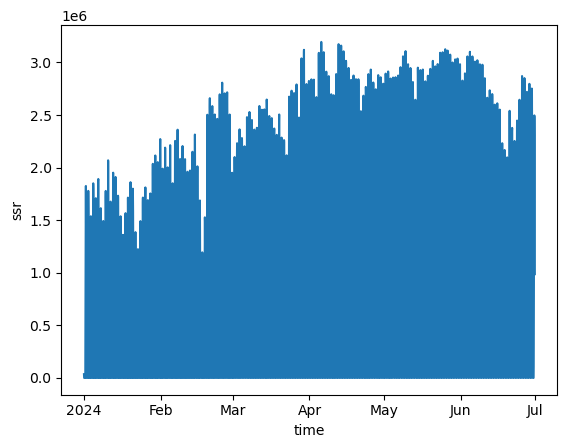

In [18]:
test.ssr.mean(['latitude', 'longitude']).plot()

In [1]:
import xarray as xr
import numpy as np

In [2]:
jan = xr.open_dataset('sw-Jan2024.nc', chunks={})
feb = xr.open_dataset('sw-Feb2024.nc', chunks={})
march = xr.open_dataset('sw-March2024.nc', chunks={})
apr = xr.open_dataset('sw-April20241.nc', chunks={})
may = xr.open_dataset('sw-May2024.nc', chunks={})

In [3]:
jan

<xarray.Dataset> Size: 20MB
Dimensions:    (longitude: 81, latitude: 41, time: 744)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-01-01 ... 2024-01-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 20MB dask.array<chunksize=(744, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 14:52:37 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [4]:
feb

<xarray.Dataset> Size: 18MB
Dimensions:    (longitude: 81, latitude: 41, time: 696)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-02-01 ... 2024-02-29T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 18MB dask.array<chunksize=(696, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 14:56:00 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
march

<xarray.Dataset> Size: 20MB
Dimensions:    (longitude: 81, latitude: 41, time: 744)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-03-01 ... 2024-03-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 20MB dask.array<chunksize=(744, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:32:13 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [6]:
apr

<xarray.Dataset> Size: 38MB
Dimensions:    (longitude: 81, latitude: 41, expver: 2, time: 720)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 6kB 2024-04-01 ... 2024-04-30T23:00:00
Data variables:
    ssr        (time, expver, latitude, longitude) float64 38MB dask.array<chunksize=(720, 2, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-10 15:33:18 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [7]:
may

<xarray.Dataset> Size: 20MB
Dimensions:    (longitude: 81, latitude: 41, time: 744)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-05-01 ... 2024-05-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 20MB dask.array<chunksize=(744, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 15:00:25 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Make a movie to determine how to slice and clean April

In [9]:
from xmovie import Movie
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
def plot_ssr(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    da.isel(time=tt).plot(ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude');    
    return ax, da

In [28]:
ex0 = apr.ssr.isel(expver=0)
ex1 = apr.ssr.isel(expver=1)

(<Axes: title={'center': 'expver = 1, time = 2024-04-05T04:00:00'}, xlabel='Longitude', ylabel='Latitude'>,
 <xarray.DataArray 'ssr' (time: 720, latitude: 41, longitude: 81)> Size: 19MB
 dask.array<getitem, shape=(720, 41, 81), dtype=float64, chunksize=(720, 41, 81), chunktype=numpy.ndarray>
 Coordinates:
   * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
   * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
     expver     int32 4B 1
   * time       (time) datetime64[ns] 6kB 2024-04-01 ... 2024-04-30T23:00:00
 Attributes:
     units:          J m**-2
     long_name:      Surface net short-wave (solar) radiation
     standard_name:  surface_net_downward_shortwave_flux)

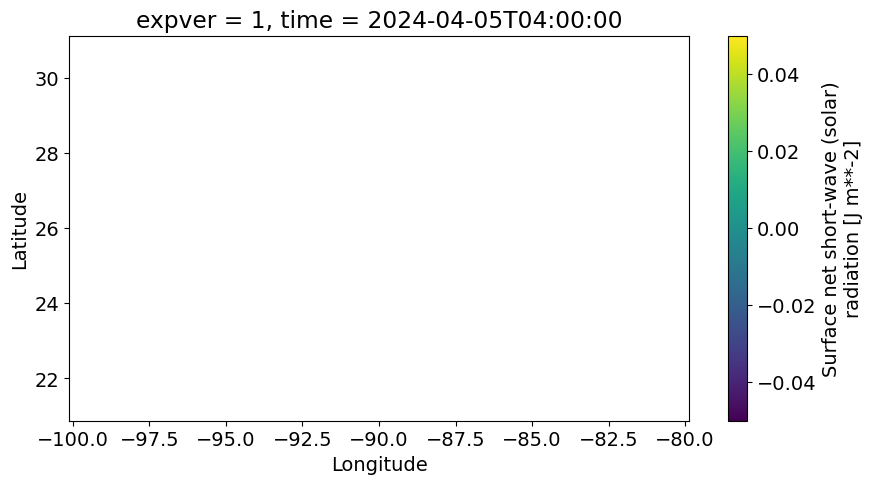

In [29]:
fig = plt.figure(figsize= (10, 5))

plot_ssr(ex0, fig, 100)

In [30]:
expver0 = Movie(ex0, plotfunc=plot_ssr, input_check=False)

expver1 = Movie(ex1, plotfunc=plot_ssr, input_check=False)

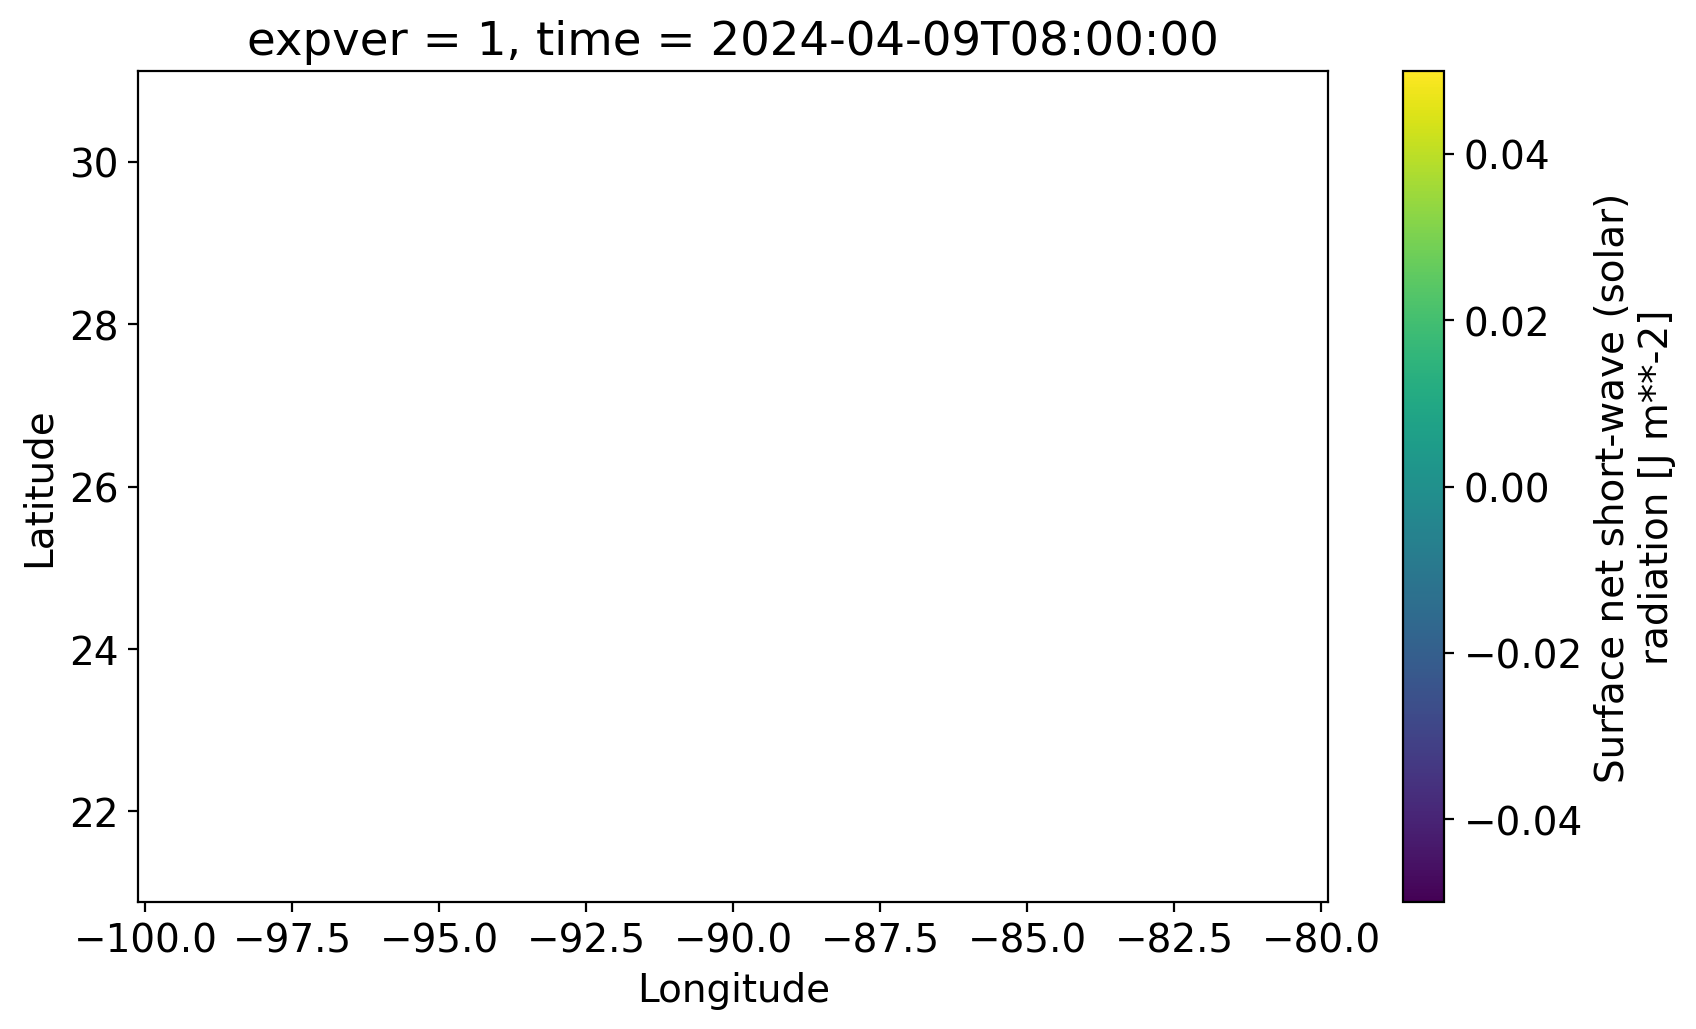

In [31]:
expver0.preview(200)

In [32]:
expver0.save('ssr_expver0.mp4', overwrite_existing=True, progress=True,)

  0%|          | 0/720 [00:00<?, ?it/s]

Movie created at ssr_expver0.mp4


In [33]:
expver1.save('ssr_expver1.mp4', overwrite_existing=True, progress=True,)

  0%|          | 0/720 [00:00<?, ?it/s]

Movie created at ssr_expver1.mp4


## Slice according to movie notes (in keynote slide)

In [8]:
first_slice = apr.ssr.isel(expver=0).isel(time=slice(0, 7))
second_slice = apr.ssr.isel(expver=1).isel(time=slice(7, None))
april = xr.merge([first_slice.drop_vars('expver'), second_slice.drop_vars('expver')])
april_resampled = april.resample(time='D').mean()

In [9]:
april

<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 81, latitude: 41, time: 720)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-04-01 ... 2024-04-30T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 19MB dask.array<chunksize=(720, 41, 81), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

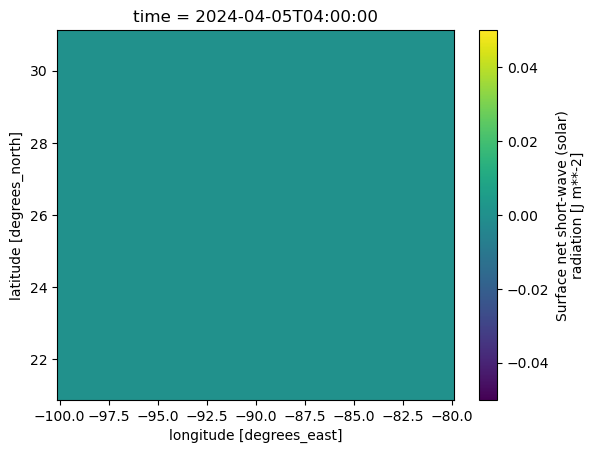

In [11]:
april.ssr[100].plot()

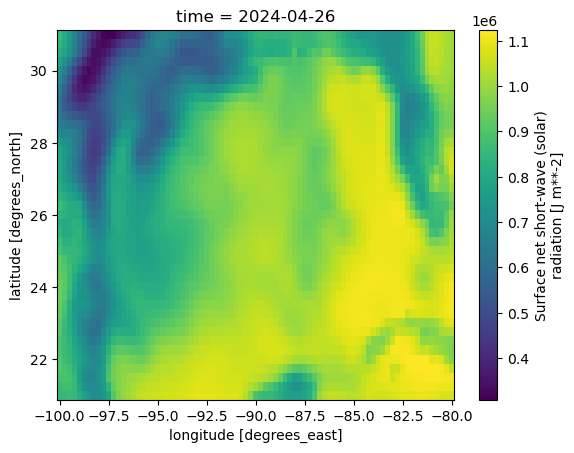

In [11]:
april_resampled[25].plot()

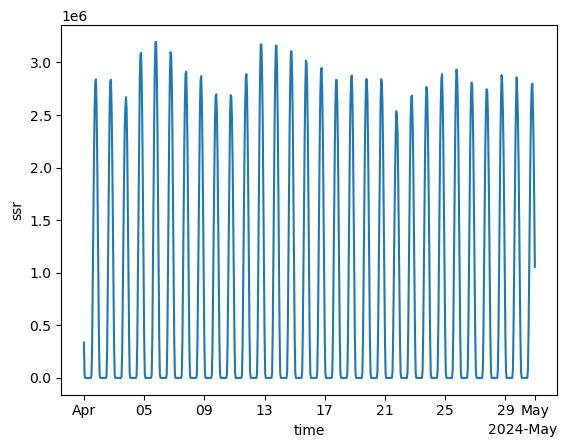

In [13]:
april.ssr.mean(['latitude', 'longitude']).plot()

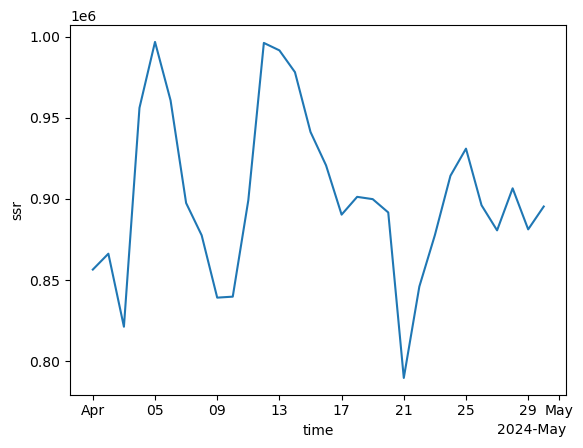

In [15]:
april_resampled.ssr.mean(['latitude', 'longitude']).plot()

In [16]:
april

<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 81, latitude: 41, time: 720)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-04-01 ... 2024-04-30T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 19MB dask.array<chunksize=(720, 41, 81), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

In [30]:
latest = xr.merge([jan.ssr, feb.ssr, march.ssr, april.ssr, may.ssr])

In [33]:
latest

<xarray.Dataset> Size: 97MB
Dimensions:    (longitude: 81, latitude: 41, time: 3648)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 97MB dask.array<chunksize=(3648, 41, 81), meta=np.ndarray>
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

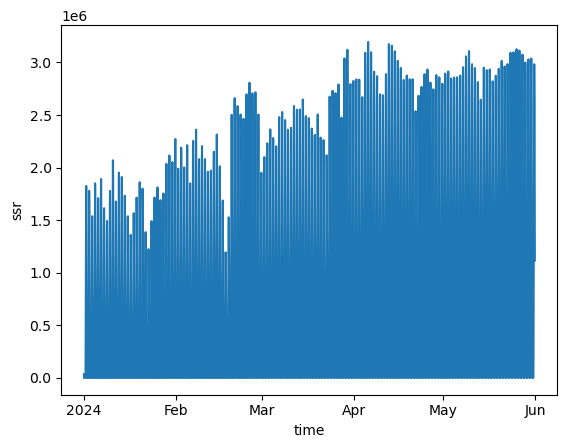

In [32]:
latest.ssr.mean(['latitude', 'longitude']).plot()

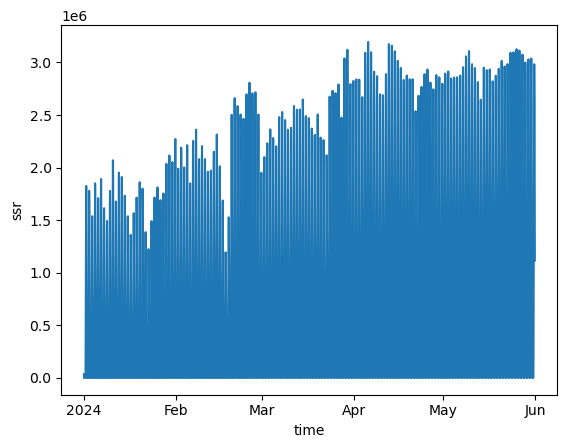

In [42]:
test.ssr.mean(['latitude', 'longitude']).plot()

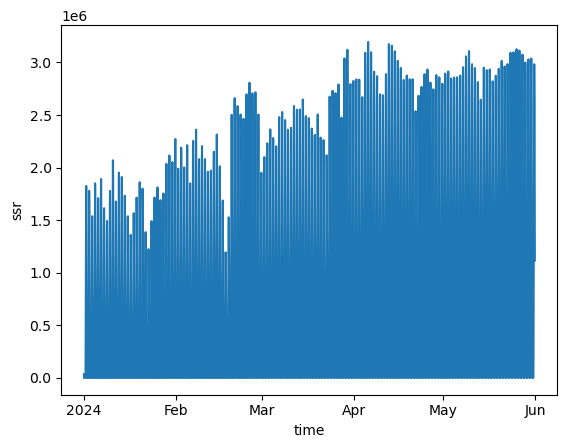

In [37]:
tt.ssr.mean(['latitude', 'longitude']).plot()

In [34]:
latest.load()

<xarray.Dataset> Size: 97MB
Dimensions:    (longitude: 81, latitude: 41, time: 3648)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 97MB 9.976e+04 ... 6.552e+05
Attributes:
    units:          J m**-2
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux

In [35]:
latest.to_netcdf('sw2024.nc')

In [36]:
tt = xr.open_dataset('sw2024.nc', chunks={})

In [38]:
#updating 2024 sst to zarr
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr.zarr')
latest.to_zarr(gcsmap_ds, mode='w')

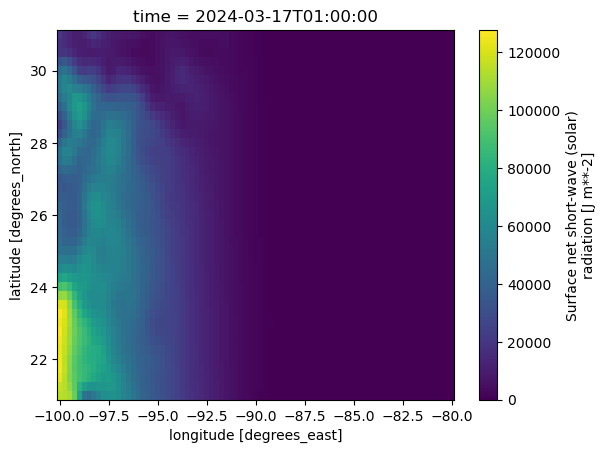

In [22]:
latest.isel(time=1825).plot()

In [39]:
#check 2024 sst to zarr upload was successful
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token) 

test = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-ssr.zarr'))

In [40]:
test

<xarray.Dataset> Size: 97MB
Dimensions:    (latitude: 41, longitude: 81, time: 3648)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00
Data variables:
    ssr        (time, latitude, longitude) float64 97MB dask.array<chunksize=(456, 11, 21), meta=np.ndarray>
Attributes:
    long_name:      Surface net short-wave (solar) radiation
    standard_name:  surface_net_downward_shortwave_flux
    units:          J m**-2

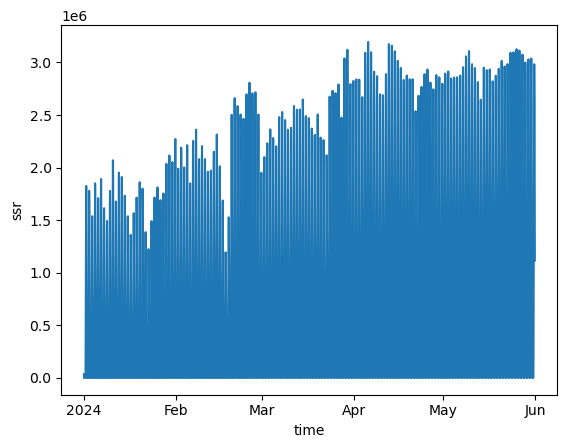

In [41]:
test.ssr.mean(['latitude', 'longitude']).plot()

In [2]:
jan = xr.open_dataset('sst-2024Jan.nc', chunks={})
feb = xr.open_dataset('sst-2024Feb.nc', chunks={})
march = xr.open_dataset('sst-2024March.nc', chunks={})
apr = xr.open_dataset('sst-2024April.nc', chunks={})
may = xr.open_dataset('sst-2024May.nc', chunks={})

In [3]:
jan

<xarray.Dataset> Size: 20MB
Dimensions:    (longitude: 81, latitude: 41, time: 744)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-01-01 ... 2024-01-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 20MB dask.array<chunksize=(744, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:53:36 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [4]:
feb

<xarray.Dataset> Size: 18MB
Dimensions:    (longitude: 81, latitude: 41, time: 696)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-02-01 ... 2024-02-29T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 18MB dask.array<chunksize=(696, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:55:49 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
march

<xarray.Dataset> Size: 20MB
Dimensions:    (longitude: 81, latitude: 41, time: 744)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-03-01 ... 2024-03-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 20MB dask.array<chunksize=(744, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:56:51 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [6]:
apr

<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 81, latitude: 41, time: 720)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-04-01 ... 2024-04-30T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 19MB dask.array<chunksize=(720, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:57:51 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [7]:
may

<xarray.Dataset> Size: 20MB
Dimensions:    (longitude: 81, latitude: 41, time: 744)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 6kB 2024-05-01 ... 2024-05-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 20MB dask.array<chunksize=(744, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 15:01:54 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [8]:
latest = xr.merge([jan, feb, march, apr, may])

In [9]:
latest

<xarray.Dataset> Size: 97MB
Dimensions:    (longitude: 81, latitude: 41, time: 3648)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 97MB dask.array<chunksize=(3648, 41, 81), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:53:36 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [10]:
latest.load()

<xarray.Dataset> Size: 97MB
Dimensions:    (longitude: 81, latitude: 41, time: 3648)
Coordinates:
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 97MB nan nan ... 303.2 303.2
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:53:36 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [11]:
#upload 2024 jan-may
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-sst.zarr')
latest.to_zarr(gcsmap_ds, mode='w')

In [12]:
test = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/2024-sst.zarr'))

In [13]:
test

<xarray.Dataset> Size: 97MB
Dimensions:    (latitude: 41, longitude: 81, time: 3648)
Coordinates:
  * latitude   (latitude) float32 164B 31.0 30.75 30.5 30.25 ... 21.5 21.25 21.0
  * longitude  (longitude) float32 324B -100.0 -99.75 -99.5 ... -80.25 -80.0
  * time       (time) datetime64[ns] 29kB 2024-01-01 ... 2024-05-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float64 97MB dask.array<chunksize=(456, 11, 21), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-06 16:53:36 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

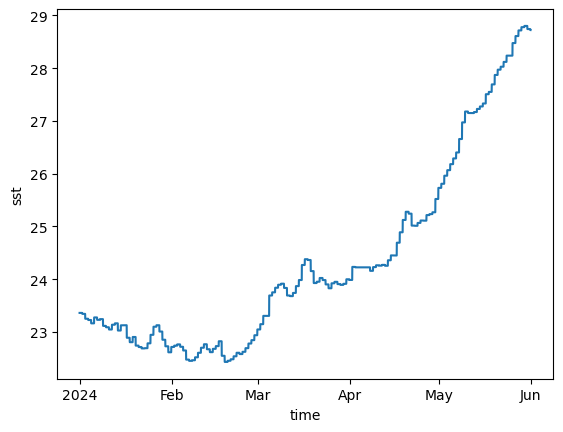

In [15]:
(test.sst-273.15).mean(['latitude', 'longitude']).plot()

In [11]:
#updating era gom ds to incl end of 2023
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr')
gom.to_zarr(gcsmap_ds, mode='w')

In [12]:
#test if upload worked

era23 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))

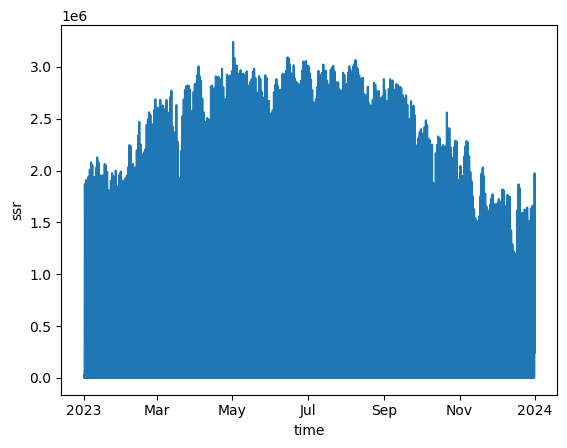

In [13]:
era23.ssr.mean(['latitude', 'longitude']).plot()

In [2]:
import numpy as np

In [3]:
for i in np.arange(2010, 2023):
    print(f'downloaded year {i}:')

downloaded year 2010:
downloaded year 2011:
downloaded year 2012:
downloaded year 2013:
downloaded year 2014:
downloaded year 2015:
downloaded year 2016:
downloaded year 2017:
downloaded year 2018:
downloaded year 2019:
downloaded year 2020:
downloaded year 2021:
downloaded year 2022:


In [1]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 'sea_surface_temperature',
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'area': [
            31, -130, -30,
            -30,
        ],
    },
    '2023-sst_larger_region.nc')

2024-04-26 13:09:11,398 INFO Welcome to the CDS
2024-04-26 13:09:11,399 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-26 13:09:11,702 INFO Request is queued
2024-04-26 13:09:16,852 INFO Request is running
2024-04-26 13:19:33,035 INFO Request is completed
2024-04-26 13:19:33,036 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data6/adaptor.mars.internal-1714137442.8656983-22148-15-3420c0a3-103d-4f25-acf4-58f5dd5f3b2e.nc to 2023-sst_larger_region.nc (1.6G)
2024-04-26 13:26:33,777 INFO Download rate 3.9M/s     


Result(content_length=1721291100,content_type=application/x-netcdf,location=https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data6/adaptor.mars.internal-1714137442.8656983-22148-15-3420c0a3-103d-4f25-acf4-58f5dd5f3b2e.nc)

In [4]:
import cdsapi

c = cdsapi.Client()

for i in np.arange(2010, 2023):
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                '10m_u_component_of_wind', '10m_v_component_of_wind',
            ],
            'year': f'{i}',
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                31, -100, -21,
                -72,
            ],
        },
        f'year_{i}.nc')
    print(f'downloaded year {i}')

2024-04-25 20:16:30,295 INFO Welcome to the CDS
2024-04-25 20:16:30,296 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-25 20:16:30,575 INFO Request is queued
2024-04-25 20:16:31,708 INFO Request is running
2024-04-25 20:30:52,967 INFO Request is completed
2024-04-25 20:30:52,968 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data4/adaptor.mars.internal-1714076903.6799965-5730-5-57bdc9a1-2a94-4ddb-a3e7-9fabc015d0b9.nc to year_2010.nc (789.2M)
2024-04-25 20:32:23,060 INFO Download rate 8.8M/s    
2024-04-25 20:32:23,773 INFO Welcome to the CDS
2024-04-25 20:32:23,774 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2010


2024-04-25 20:32:23,953 INFO Request is queued
2024-04-25 20:32:26,718 INFO Request is running
2024-04-25 20:46:46,842 INFO Request is completed
2024-04-25 20:46:46,843 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data7/adaptor.mars.internal-1714077856.414562-4397-8-c91bbca6-476c-4cb7-babb-e9f28f76d0b8.nc to year_2011.nc (789.2M)
2024-04-25 20:50:03,654 INFO Download rate 4M/s      
2024-04-25 20:50:04,540 INFO Welcome to the CDS
2024-04-25 20:50:04,542 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2011


2024-04-25 20:50:04,714 INFO Request is queued
2024-04-25 20:50:09,947 INFO Request is running
2024-04-25 21:02:27,714 INFO Request is completed
2024-04-25 21:02:27,715 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data2/adaptor.mars.internal-1714078861.6947837-31570-4-a976fb30-5ae0-4030-bed3-aed269fdf2ce.nc to year_2012.nc (791.4M)
2024-04-25 21:10:04,814 INFO Download rate 1.7M/s    
2024-04-25 21:10:05,814 INFO Welcome to the CDS
2024-04-25 21:10:05,814 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2012


2024-04-25 21:10:06,014 INFO Request is queued
2024-04-25 21:10:08,773 INFO Request is running
2024-04-25 21:24:29,693 INFO Request is completed
2024-04-25 21:24:29,714 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data4/adaptor.mars.internal-1714080099.7860472-5548-2-4ea48d0d-286a-482c-9d14-35f754caff23.nc to year_2013.nc (789.2M)
2024-04-25 21:37:57,752 INFO Download rate 1000.2K/s 
2024-04-25 21:37:58,814 INFO Welcome to the CDS
2024-04-25 21:37:58,815 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2013


2024-04-25 21:37:59,014 INFO Request is queued
2024-04-25 21:38:00,145 INFO Request is running
2024-04-25 21:50:21,275 INFO Request is completed
2024-04-25 21:50:21,276 INFO Downloading https://download-0016.copernicus-climate.eu/cache-compute-0016/cache/data2/adaptor.mars.internal-1714081697.6689367-4490-11-0138faa5-95dc-4c38-a847-cecc4e04e932.nc to year_2014.nc (789.2M)
2024-04-25 21:53:52,104 INFO Download rate 3.7M/s    
2024-04-25 21:53:52,836 INFO Welcome to the CDS
2024-04-25 21:53:52,837 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2014


2024-04-25 21:53:52,982 INFO Request is queued
2024-04-25 21:53:55,742 INFO Request is running
2024-04-25 22:08:15,412 INFO Request is completed
2024-04-25 22:08:15,413 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data6/adaptor.mars.internal-1714082718.3940353-31598-18-45cc472f-d208-4e8b-b078-d20aa40bcee7.nc to year_2015.nc (789.2M)
2024-04-25 22:15:36,289 INFO Download rate 1.8M/s    
2024-04-25 22:15:37,014 INFO Welcome to the CDS
2024-04-25 22:15:37,014 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2015


2024-04-25 22:15:37,158 INFO Request is queued
2024-04-25 22:15:38,286 INFO Request is running
2024-04-25 22:29:59,515 INFO Request is completed
2024-04-25 22:29:59,516 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data6/adaptor.mars.internal-1714084020.0645704-28966-12-91643d3a-61ee-4f34-929c-841788ec9b9c.nc to year_2016.nc (791.4M)
2024-04-25 22:35:25,721 INFO Download rate 2.4M/s    
2024-04-25 22:35:26,394 INFO Welcome to the CDS
2024-04-25 22:35:26,395 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2016


2024-04-25 22:35:26,543 INFO Request is queued
2024-04-25 22:35:27,673 INFO Request is running
2024-04-25 22:49:48,959 INFO Request is completed
2024-04-25 22:49:48,960 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data9/adaptor.mars.internal-1714085179.24567-17631-9-cf71f68a-1f6e-413d-a043-b682e15fe577.nc to year_2017.nc (789.2M)
2024-04-25 22:57:49,105 INFO Download rate 1.6M/s    
2024-04-25 22:57:49,912 INFO Welcome to the CDS
2024-04-25 22:57:49,912 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2017


2024-04-25 22:57:50,058 INFO Request is queued
2024-04-25 22:57:51,187 INFO Request is running
2024-04-25 23:12:12,499 INFO Request is completed
2024-04-25 23:12:12,500 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data7/adaptor.mars.internal-1714086535.354669-3697-15-9918a6b4-136f-43ba-8a50-c3128ee8324f.nc to year_2018.nc (789.2M)
2024-04-25 23:27:28,866 INFO Download rate 881.9K/s  
2024-04-25 23:27:29,532 INFO Welcome to the CDS
2024-04-25 23:27:29,533 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2018


2024-04-25 23:27:29,749 INFO Request is queued
2024-04-25 23:27:30,879 INFO Request is running
2024-04-25 23:41:52,144 INFO Request is completed
2024-04-25 23:41:52,145 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data4/adaptor.mars.internal-1714088352.76547-9824-3-a74e74c6-59dc-4064-bdff-b7a39a35425c.nc to year_2019.nc (789.2M)
2024-04-25 23:47:11,001 INFO Download rate 2.5M/s    
2024-04-25 23:47:11,653 INFO Welcome to the CDS
2024-04-25 23:47:11,653 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2019


2024-04-25 23:47:11,808 INFO Request is queued
2024-04-25 23:47:12,935 INFO Request is running
2024-04-25 23:59:33,455 INFO Request is completed
2024-04-25 23:59:33,456 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data4/adaptor.mars.internal-1714089461.5583036-19042-10-4cc18755-c277-4e24-bded-c700761b48aa.nc to year_2020.nc (791.4M)
2024-04-26 00:05:35,580 INFO Download rate 2.2M/s    
2024-04-26 00:05:36,228 INFO Welcome to the CDS
2024-04-26 00:05:36,228 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2020


2024-04-26 00:05:36,383 INFO Request is queued
2024-04-26 00:05:37,511 INFO Request is running
2024-04-26 00:15:57,541 INFO Request is completed
2024-04-26 00:15:57,542 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data9/adaptor.mars.internal-1714090407.7170308-28008-17-17cdc555-f5fe-4594-8c54-a7bb219ad488.nc to year_2021.nc (789.2M)
2024-04-26 00:17:30,916 INFO Download rate 8.5M/s    
2024-04-26 00:17:31,579 INFO Welcome to the CDS
2024-04-26 00:17:31,580 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2021


2024-04-26 00:17:31,726 INFO Request is queued
2024-04-26 00:17:32,855 INFO Request is running
2024-04-26 00:31:54,093 INFO Request is completed
2024-04-26 00:31:54,094 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data8/adaptor.mars.internal-1714091323.9469123-1199-15-e2d56131-80ab-4f8d-bde0-d268486fd1ee.nc to year_2022.nc (789.2M)
2024-04-26 00:41:10,671 INFO Download rate 1.4M/s    


downloaded year 2022


In [9]:
import cdsapi

c = cdsapi.Client()

for i in np.arange(2010, 2023):
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'format': 'netcdf',
            'variable': [
                'sea_surface_temperature', 'surface_latent_heat_flux', 'surface_net_solar_radiation',
                'surface_net_thermal_radiation', 'surface_sensible_heat_flux',
            ],
            'year': f'{i}',
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'area': [
                31, -100, 21,
                -72,
            ],
        },
        f'year_{i}.nc')
    print(f'downloaded year {i}')

2024-04-21 16:26:42,170 INFO Welcome to the CDS
2024-04-21 16:26:42,171 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-04-21 16:26:42,409 INFO Request is queued
2024-04-21 16:26:43,541 INFO Request is running
2024-04-21 17:03:11,223 INFO Request is completed
2024-04-21 17:03:11,224 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data3/adaptor.mars.internal-1713718771.3902423-32542-11-b4bba054-90a7-4fcc-a1a8-d428e9b4efac.nc to year_2010.nc (387.1M)
2024-04-21 17:04:22,699 INFO Download rate 5.4M/s    
2024-04-21 17:04:23,346 INFO Welcome to the CDS
2024-04-21 17:04:23,347 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2010


2024-04-21 17:04:23,565 INFO Request is queued
2024-04-21 17:04:24,693 INFO Request is running
2024-04-21 17:40:52,326 INFO Request is completed
2024-04-21 17:40:52,326 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data4/adaptor.mars.internal-1713721021.015928-27137-2-2a7de9b1-fe0b-42f4-ac31-28a00182f365.nc to year_2011.nc (387.1M)
2024-04-21 17:44:30,494 INFO Download rate 1.8M/s    
2024-04-21 17:44:31,318 INFO Welcome to the CDS
2024-04-21 17:44:31,318 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2011


2024-04-21 17:44:31,481 INFO Request is queued
2024-04-21 17:44:32,615 INFO Request is running
2024-04-21 18:25:01,377 INFO Request is completed
2024-04-21 18:25:01,378 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data0/adaptor.mars.internal-1713723607.6834393-22553-15-1bbc56a2-5db7-4f85-aed0-9f7228af69ae.nc to year_2012.nc (388.1M)
2024-04-21 18:27:53,516 INFO Download rate 2.3M/s    
2024-04-21 18:27:54,230 INFO Welcome to the CDS
2024-04-21 18:27:54,231 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2012


2024-04-21 18:27:54,453 INFO Request is queued
2024-04-21 18:27:55,586 INFO Request is running
2024-04-21 19:04:22,911 INFO Request is completed
2024-04-21 19:04:22,912 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data8/adaptor.mars.internal-1713726017.2404997-32240-17-7455e78e-e33c-4242-b677-cc6801f66cf5.nc to year_2013.nc (387.1M)
2024-04-21 19:05:15,402 INFO Download rate 7.4M/s    
2024-04-21 19:05:15,663 INFO Welcome to the CDS
2024-04-21 19:05:15,664 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2013


2024-04-21 19:05:15,841 INFO Request is queued
2024-04-21 19:05:16,972 INFO Request is running
2024-04-21 19:41:44,267 INFO Request is completed
2024-04-21 19:41:44,268 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data0/adaptor.mars.internal-1713728232.6619859-2562-9-d05db2fc-b2bf-4e96-9ccf-722d1dfd5c60.nc to year_2014.nc (387.1M)
2024-04-21 19:42:21,460 INFO Download rate 10.4M/s   
2024-04-21 19:42:21,720 INFO Welcome to the CDS
2024-04-21 19:42:21,721 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2014


2024-04-21 19:42:21,911 INFO Request is queued
2024-04-21 19:42:23,041 INFO Request is running
2024-04-21 20:20:50,904 INFO Request is completed
2024-04-21 20:20:50,904 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data1/adaptor.mars.internal-1713730483.9620836-14302-11-d218abfe-3081-4b8f-9433-ded96a364573.nc to year_2015.nc (387.1M)
2024-04-21 20:23:54,625 INFO Download rate 2.1M/s    
2024-04-21 20:23:55,360 INFO Welcome to the CDS
2024-04-21 20:23:55,360 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2015


2024-04-21 20:23:55,497 INFO Request is queued
2024-04-21 20:23:56,630 INFO Request is running
2024-04-21 21:00:23,888 INFO Request is completed
2024-04-21 21:00:23,889 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data9/adaptor.mars.internal-1713732960.7904518-30043-16-1517c676-c37e-4b68-9058-8a1ef834f101.nc to year_2016.nc (388.1M)
2024-04-21 21:03:21,877 INFO Download rate 2.2M/s    
2024-04-21 21:03:22,538 INFO Welcome to the CDS
2024-04-21 21:03:22,538 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2016


2024-04-21 21:03:22,694 INFO Request is queued
2024-04-21 21:03:23,823 INFO Request is running
2024-04-21 21:39:51,181 INFO Request is completed
2024-04-21 21:39:51,181 INFO Downloading https://download-0001-clone.copernicus-climate.eu/cache-compute-0001/cache/data1/adaptor.mars.internal-1713735310.1657887-1976-12-4d9cf3d0-a00b-47fc-ab67-1629b8dc2758.nc to year_2017.nc (387.1M)
2024-04-21 21:41:45,024 INFO Download rate 3.4M/s    
2024-04-21 21:41:45,694 INFO Welcome to the CDS
2024-04-21 21:41:45,694 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2017


2024-04-21 21:41:45,832 INFO Request is queued
2024-04-21 21:41:46,961 INFO Request is running
2024-04-21 22:18:14,142 INFO Request is completed
2024-04-21 22:18:14,143 INFO Downloading https://download-0005-clone.copernicus-climate.eu/cache-compute-0005/cache/data9/adaptor.mars.internal-1713737617.652036-5630-9-9eb6b57b-b95d-4b30-9495-ebb3d26fee6a.nc to year_2018.nc (387.1M)
2024-04-21 22:19:13,206 INFO Download rate 6.6M/s    
2024-04-21 22:19:13,462 INFO Welcome to the CDS
2024-04-21 22:19:13,462 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2018


2024-04-21 22:19:13,614 INFO Request is queued
2024-04-21 22:19:14,742 INFO Request is running
2024-04-21 22:55:41,928 INFO Request is completed
2024-04-21 22:55:41,929 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data7/adaptor.mars.internal-1713739945.1762524-4108-14-a07d8b77-a05d-4dbe-8cb4-c7da2eb10291.nc to year_2019.nc (387.1M)
2024-04-21 22:56:49,921 INFO Download rate 5.7M/s    
2024-04-21 22:56:50,701 INFO Welcome to the CDS
2024-04-21 22:56:50,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2019


2024-04-21 22:56:50,884 INFO Request is queued
2024-04-21 22:56:52,016 INFO Request is running
2024-04-21 23:33:19,265 INFO Request is completed
2024-04-21 23:33:19,265 INFO Downloading https://download-0010-clone.copernicus-climate.eu/cache-compute-0010/cache/data4/adaptor.mars.internal-1713742163.1184433-7207-14-a34ebc07-58bb-44c3-9f5a-7d8480cb8ac6.nc to year_2020.nc (388.1M)
2024-04-21 23:35:07,943 INFO Download rate 3.6M/s    
2024-04-21 23:35:08,591 INFO Welcome to the CDS
2024-04-21 23:35:08,592 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2020


2024-04-21 23:35:08,726 INFO Request is queued
2024-04-21 23:35:09,854 INFO Request is running
2024-04-22 00:11:37,188 INFO Request is completed
2024-04-22 00:11:37,188 INFO Downloading https://download-0017.copernicus-climate.eu/cache-compute-0017/cache/data5/adaptor.mars.internal-1713744422.309441-4814-15-a733e529-d84c-4ac6-b073-1f0c8d9d6e07.nc to year_2021.nc (387.1M)
2024-04-22 00:14:13,366 INFO Download rate 2.5M/s    
2024-04-22 00:14:14,029 INFO Welcome to the CDS
2024-04-22 00:14:14,029 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


downloaded year 2021


2024-04-22 00:14:14,224 INFO Request is queued
2024-04-22 00:14:15,354 INFO Request is running
2024-04-22 00:52:43,744 INFO Request is completed
2024-04-22 00:52:43,744 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data9/adaptor.mars.internal-1713746856.3349352-19604-11-9b8ad057-ac59-4865-9c27-fd347ba86858.nc to year_2022.nc (387.1M)
2024-04-22 00:54:18,800 INFO Download rate 4.1M/s    


downloaded year 2022


In [5]:
import xarray as xr

In [6]:
ds = xr.open_mfdataset('year_*.nc')

In [7]:
ds

<xarray.Dataset> Size: 43GB
Dimensions:    (longitude: 113, latitude: 209, time: 113952)
Coordinates:
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * latitude   (latitude) float32 836B 31.0 30.75 30.5 ... -20.5 -20.75 -21.0
  * time       (time) datetime64[ns] 912kB 2010-01-01 ... 2022-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float64 22GB dask.array<chunksize=(8760, 209, 113), meta=np.ndarray>
    v10        (time, latitude, longitude) float64 22GB dask.array<chunksize=(8760, 209, 113), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-25 20:29:42 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [8]:
ds.chunk({'time':2374.0})

<xarray.Dataset> Size: 43GB
Dimensions:    (longitude: 113, latitude: 209, time: 113952)
Coordinates:
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * latitude   (latitude) float32 836B 31.0 30.75 30.5 ... -20.5 -20.75 -21.0
  * time       (time) datetime64[ns] 912kB 2010-01-01 ... 2022-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float64 22GB dask.array<chunksize=(2374, 209, 113), meta=np.ndarray>
    v10        (time, latitude, longitude) float64 22GB dask.array<chunksize=(2374, 209, 113), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-25 20:29:42 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [9]:
#uploading 2010-2022 wind ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/uv_2010_22.zarr')
ds.chunk({'time':2374.0}).to_zarr(gcsmap_ds, mode='w')

In [11]:
test_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/uv_2010_22.zarr'))

In [12]:
test_ds

<xarray.Dataset> Size: 43GB
Dimensions:    (latitude: 209, longitude: 113, time: 113952)
Coordinates:
  * latitude   (latitude) float32 836B 31.0 30.75 30.5 ... -20.5 -20.75 -21.0
  * longitude  (longitude) float32 452B -100.0 -99.75 -99.5 ... -72.25 -72.0
  * time       (time) datetime64[ns] 912kB 2010-01-01 ... 2022-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float64 22GB dask.array<chunksize=(2374, 209, 113), meta=np.ndarray>
    v10        (time, latitude, longitude) float64 22GB dask.array<chunksize=(2374, 209, 113), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-25 20:29:42 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

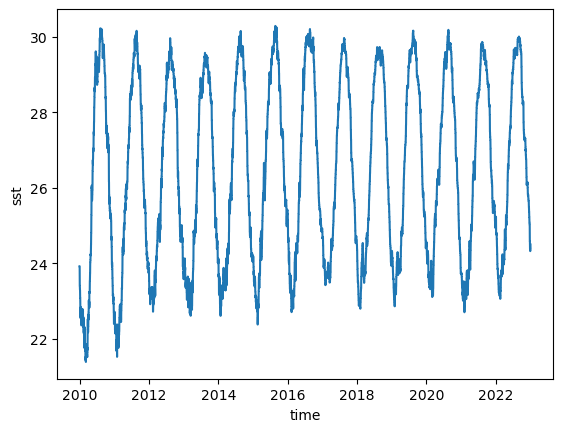

In [26]:
(test_ds.sst-273.15).mean(['latitude', 'longitude']).plot()

## ORAS5: 
> https://www.ecmwf.int/en/research/climate-reanalysis/ocean-reanalysis

> https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-oras5?tab=overview

# MERRA-2: 
> https://disc.gsfc.nasa.gov/api/jobs/results/65f9ca6b7386d42dac131f32
1.	create .netrc file following instructions 1-3 on this page https://urs.earthdata.nasa.gov/documentation/for_users/data_access/curl_and_wget
2.	subset to region, select sw/lw variables, and download list of files as .txt on this page https://disc.gsfc.nasa.gov/datasets/M2T1NXRAD_5.12.4/summary
3.	in terminal in Jupyter hub (same session as when you created .netrc, run :
`wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --content-disposition -i “downloaded_textfile.txt”`
4.	This will download each nc file for each day for 2023, might take some time (~10min)

In [2]:
import xarray as xr

In [3]:
#Link to get txt file list of diagnostics: https://disc.gsfc.nasa.gov/datasets/M2T1NXOCN_5.12.4/summary
merra = xr.open_mfdataset('MERRA2_*.tavg1_2d_ocn_Nx.*.SUB.nc', chunks={})

In [4]:
merra

<xarray.Dataset> Size: 55MB
Dimensions:   (time: 2928, lat: 21, lon: 45)
Coordinates:
  * time      (time) datetime64[ns] 23kB 2024-01-01T00:30:00 ... 2024-05-01T2...
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
Data variables:
    EFLUXICE  (time, lat, lon) float32 11MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 11MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 11MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 11MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 11MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Thu Jan 11 20...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_ocn_Nx.20240101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2024-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2024-01-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.4 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

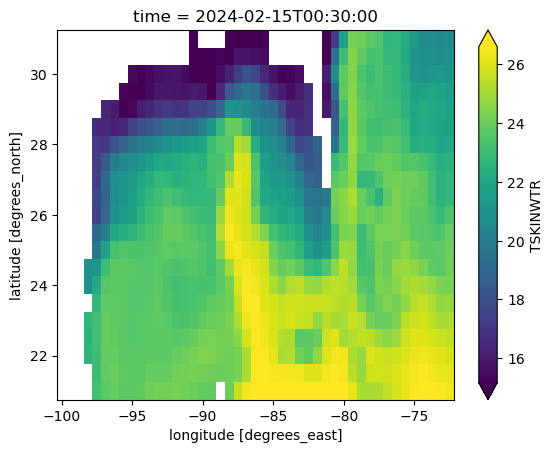

In [6]:
(merra.TSKINWTR-273.15).sel(time='2024-02-15', method='nearest').plot(robust=True)

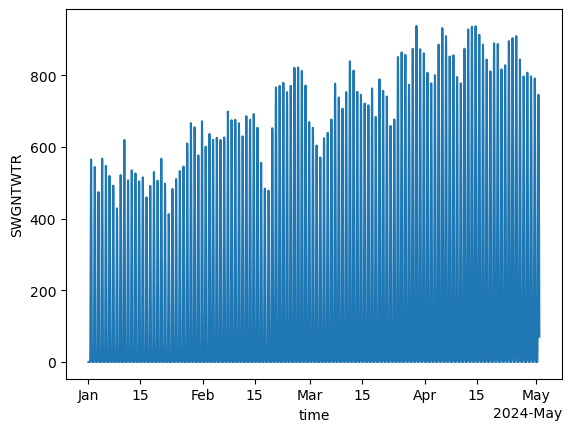

In [7]:
merra.SWGNTWTR.mean(['lat','lon']).plot()

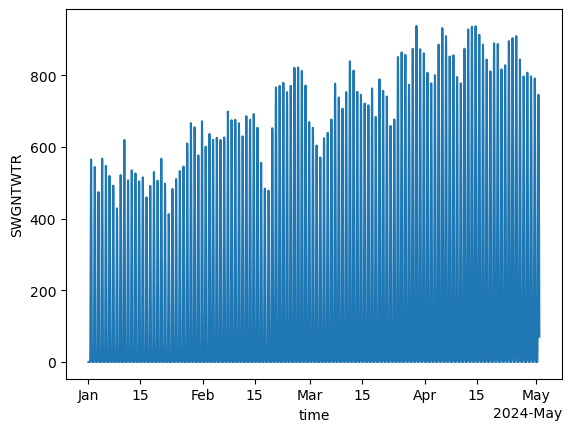

In [10]:
test_ds.SWGNTWTR.mean(['lat','lon']).plot()

In [8]:
#uploading full 2023 ocean ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean24.zarr')
merra.to_zarr(gcsmap_ds, mode='w')

In [9]:
test_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean24.zarr'))

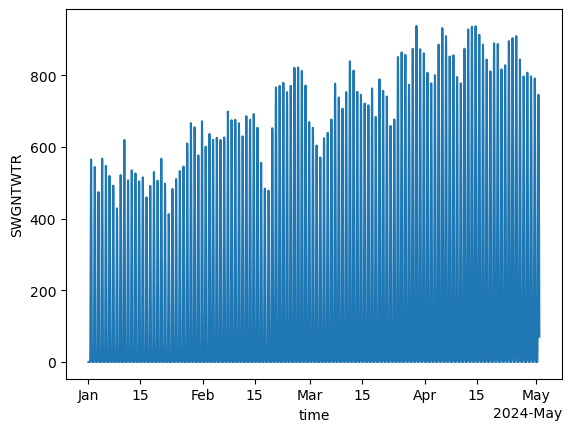

In [10]:
test_ds.SWGNTWTR.mean(['lat','lon']).plot()

In [3]:
#Link to get txt file list of diagnostics: https://disc.gsfc.nasa.gov/datasets/M2T1NXOCN_5.12.4/summary
ds = xr.open_mfdataset('MERRA2_*.*.*.SUB.nc', chunks={})

In [4]:
ds

<xarray.Dataset> Size: 615MB
Dimensions:   (time: 8760, lon: 161, lat: 109)
Coordinates:
  * time      (time) datetime64[ns] 70kB 2023-01-01T00:30:00 ... 2023-12-31T2...
  * lon       (lon) float64 1kB -130.0 -129.4 -128.8 ... -31.25 -30.62 -30.0
  * lat       (lat) float64 872B -23.0 -22.5 -22.0 -21.5 ... 29.5 30.0 30.5 31.0
Data variables:
    TSKINWTR  (time, lat, lon) float32 615MB dask.array<chunksize=(1, 109, 161), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Wed Jan 11 22...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_ocn_Nx.20230101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2023-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2023-01-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

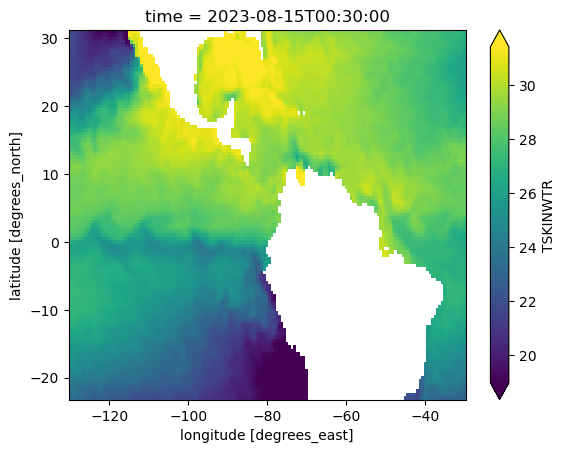

In [6]:
(ds.TSKINWTR-273.15).sel(time='2023-11-15', method='nearest').plot(robust=True)

In [11]:
from xmovie import Movie
import cmocean
%matplotlib inline

In [8]:
def plot_sst(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    da.isel(time=tt).plot(ax=ax, cmap=cmocean.cm.thermal, vmin=20, vmax=35)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid();
    
    return ax, da

In [15]:
sst = (ds.TSKINWTR-273.15).resample(time='D').mean()

In [17]:
sst.load()

<xarray.DataArray 'TSKINWTR' (time: 365, lat: 109, lon: 161)> Size: 26MB
array([[[26.425653, 26.561396, 26.553583, ..., 25.707718, 25.61885 ,
         25.50329 ],
        [26.668818, 26.627151, 26.58695 , ..., 25.828974, 25.734735,
         25.660843],
        [26.779333, 26.691605, 26.646194, ..., 25.938025, 25.909052,
         25.79447 ],
        ...,
        [19.401403, 19.431108, 19.198278, ..., 21.954382, 22.065872,
         22.082718],
        [19.367468, 19.030718, 18.803097, ..., 21.743933, 21.961298,
         21.976355],
        [18.985958, 18.342525, 18.005938, ..., 21.623816, 21.721552,
         21.755487]],

       [[26.458853, 26.439157, 26.482779, ..., 25.71585 , 25.597525,
         25.453644],
        [26.699087, 26.641794, 26.641632, ..., 25.841501, 25.73115 ,
         25.634634],
        [26.829782, 26.772003, 26.747427, ..., 25.94046 , 25.876984,
         25.760284],
...
        [19.237093, 19.038118, 18.82889 , ..., 22.894928, 23.018463,
         22.980051],
        [18.999624, 18.939077, 18.753002, ..., 22.402578, 22.651438,
         22.736807],
        [18.729565, 18.615267, 18.606762, ..., 21.999014, 22.159414,
         22.208323]],

       [[25.851572, 25.808115, 25.939138, ..., 27.351736, 27.401703,
         27.4712  ],
        [26.348969, 26.332693, 26.260916, ..., 27.56365 , 27.550467,
         27.552094],
        [26.45346 , 26.508636, 26.49643 , ..., 27.694998, 27.648773,
         27.544281],
        ...,
        [19.196012, 19.027964, 18.856535, ..., 22.958994, 23.062674,
         23.06373 ],
        [18.948576, 18.929655, 18.784718, ..., 22.260183, 22.593435,
         22.81845 ],
        [18.687101, 18.602915, 18.607634, ..., 21.983734, 22.154062,
         22.196707]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1kB -130.0 -129.4 -128.8 ... -31.25 -30.62 -30.0
  * lat      (lat) float64 872B -23.0 -22.5 -22.0 -21.5 ... 29.5 30.0 30.5 31.0
  * time     (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31

In [18]:
sst_obj = Movie(sst, plot_sst, input_check=False)

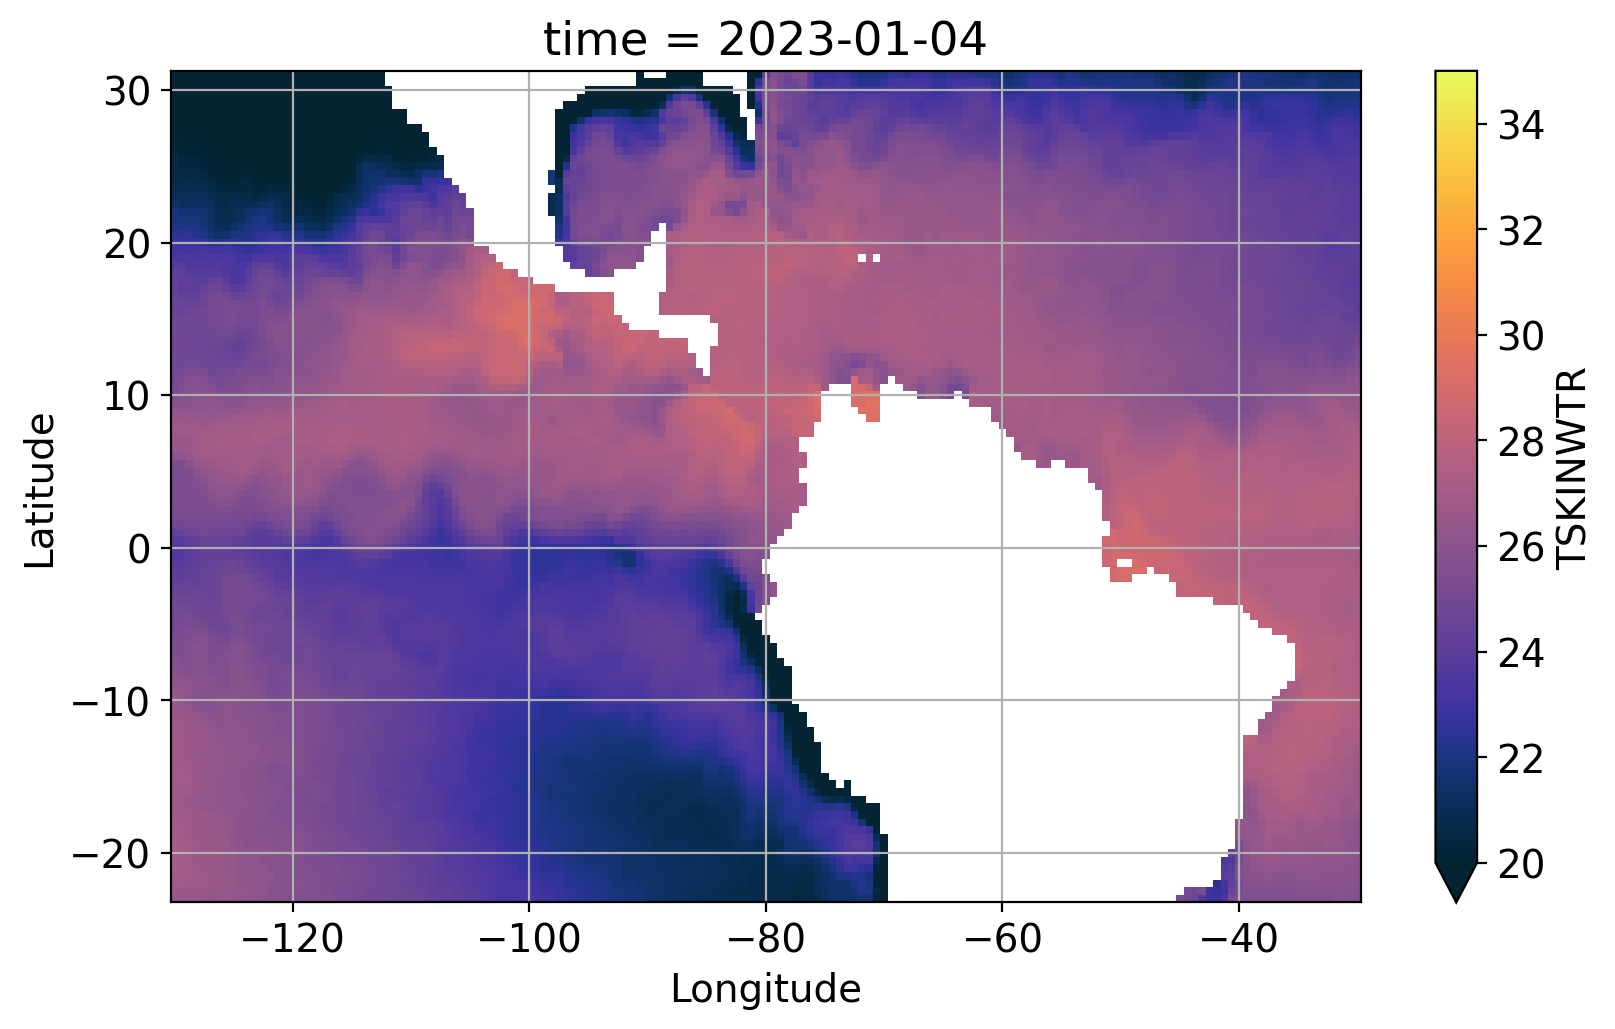

In [19]:
sst_obj.preview(3)

In [20]:
sst_obj.save('sst_m_expanded.mp4', overwrite_existing=True, progress=True,)

  0%|          | 0/365 [00:00<?, ?it/s]

Movie created at sst_m_expanded.mp4


In [5]:
113952/48

2374.0

In [6]:
ds.chunk({'time':2374})

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 113952, lon: 45, lat: 21)
Coordinates:
  * time     (time) datetime64[ns] 912kB 2010-01-01T00:30:00 ... 2022-12-31T2...
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * lat      (lat) float64 168B 21.0 21.5 22.0 22.5 23.0 ... 29.5 30.0 30.5 31.0
Data variables:
    TAUXWTR  (time, lat, lon) float32 431MB dask.array<chunksize=(2374, 21, 45), meta=np.ndarray>
    TAUYWTR  (time, lat, lon) float32 431MB dask.array<chunksize=(2374, 21, 45), meta=np.ndarray>
    U10M     (time, lat, lon) float32 431MB dask.array<chunksize=(2374, 21, 45), meta=np.ndarray>
    V10M     (time, lat, lon) float32 431MB dask.array<chunksize=(2374, 21, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Mon Mar 23 03...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Filename:                          MERRA2_300.tavg1_2d_ocn_Nx.20100101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2010-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2010-01-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [7]:
ds.nbytes/1e9

1.723866384

In [8]:
ds.load()

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 113952, lon: 45, lat: 21)
Coordinates:
  * time     (time) datetime64[ns] 912kB 2010-01-01T00:30:00 ... 2022-12-31T2...
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * lat      (lat) float64 168B 21.0 21.5 22.0 22.5 23.0 ... 29.5 30.0 30.5 31.0
Data variables:
    TAUXWTR  (time, lat, lon) float32 431MB nan nan nan ... -0.002224 -0.007023
    TAUYWTR  (time, lat, lon) float32 431MB nan nan nan ... 0.09877 0.07179
    U10M     (time, lat, lon) float32 431MB 1.638 -0.4982 ... -0.2097 -0.7422
    V10M     (time, lat, lon) float32 431MB -0.5103 -0.4405 0.88 ... 7.569 6.588
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    Conventions:                       CF-1
    History:                           Original file generated: Mon Mar 23 03...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Filename:                          MERRA2_300.tavg1_2d_ocn_Nx.20100101.nc4
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    RangeBeginningDate:                2010-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2010-01-01
    RangeEndingTime:                   23:59:59.000000
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    CDO:                               Climate Data Operators version 1.9.8 (...

In [10]:
#uploading 2010-2022 wind/windstress ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/uv_2010_22.zarr')
ds.to_zarr(gcsmap_ds, mode='w')

In [11]:
#make sure upload successful
test_ds = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/uv_2010_22.zarr'))

In [12]:
test_ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 113952, lat: 21, lon: 45)
Coordinates:
  * lat      (lat) float64 168B 21.0 21.5 22.0 22.5 23.0 ... 29.5 30.0 30.5 31.0
  * lon      (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time     (time) datetime64[ns] 912kB 2010-01-01T00:30:00 ... 2022-12-31T2...
Data variables:
    TAUXWTR  (time, lat, lon) float32 431MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    TAUYWTR  (time, lat, lon) float32 431MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    U10M     (time, lat, lon) float32 431MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
    V10M     (time, lat, lon) float32 431MB dask.array<chunksize=(14244, 3, 12), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

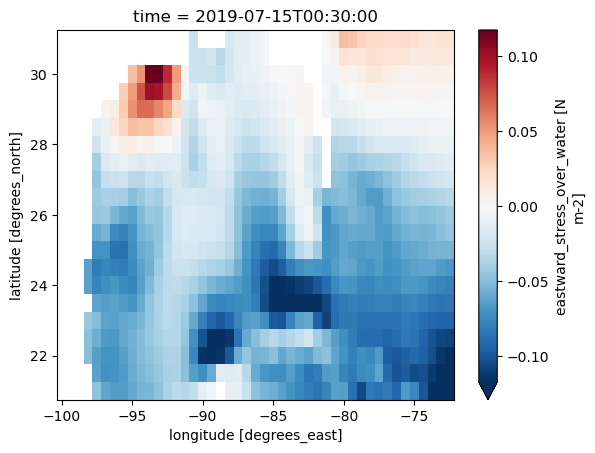

In [13]:
ds.TAUXWTR.sel(time='2019-07-15', method='nearest').plot(robust=True)

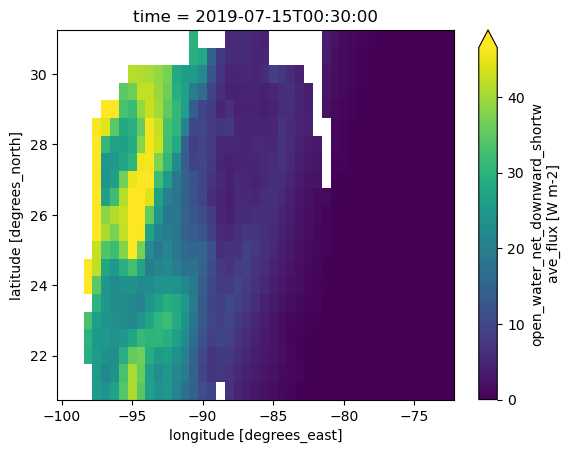

In [19]:
#success!
ds.SWGNTWTR.sel(time='2019-07-15', method='nearest').plot(robust=True)

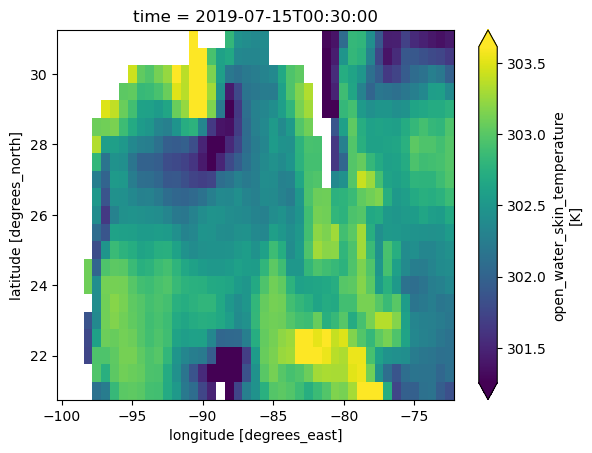

In [20]:
#success!
ds.TSKINWTR.sel(time='2019-07-15', method='nearest').plot(robust=True)

In [21]:
ds2010 = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2010_2022.zarr'))

In [23]:
ds_complete = xr.concat([ds2010, test_ds], dim='time')

In [24]:
ds_complete

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 110304, lat: 21, lon: 45)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 882kB 2010-01-01T00:30:00 ... 2022-12-31T...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

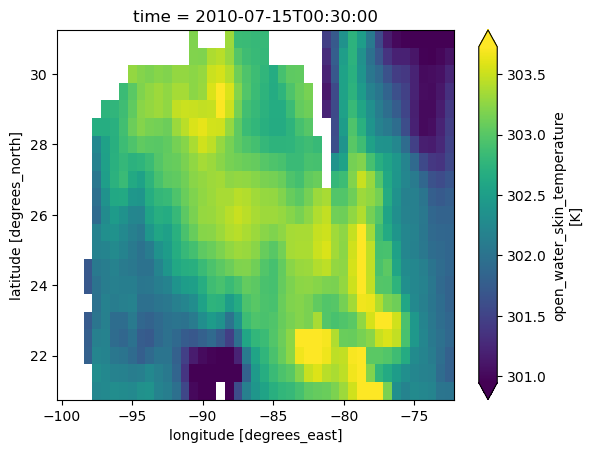

In [25]:
#success!
ds_complete.TSKINWTR.sel(time='2010-07-15', method='nearest').plot(robust=True)

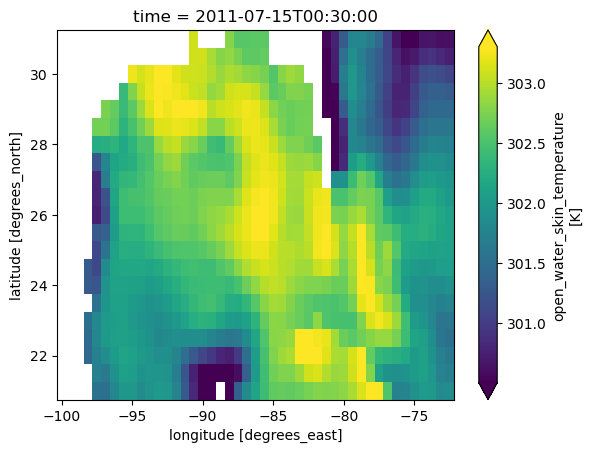

In [26]:
#success!
ds_complete.TSKINWTR.sel(time='2011-07-15', method='nearest').plot(robust=True)

In [ ]:
#uploading 2010-2022 ocean ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2011_2022.zarr')
ds.to_zarr(gcsmap_ds, mode='w')

In [28]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(15)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [29]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.47d25e26c55a4f0881fc79c115653f39/status,


In [34]:
110304/25

4412.16

In [35]:
ds_complete.chunk({'time':4412, 'lat':-1, 'lon':-1})

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 110304, lat: 21, lon: 45)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 882kB 2010-01-01T00:30:00 ... 2022-12-31T...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(4412, 21, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(4412, 21, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(4412, 21, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(4412, 21, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(4412, 21, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

In [36]:
#uploading correct 2010-2022 ocean ds
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2010_22.zarr')
ds_complete.chunk({'time':4412, 'lat':-1, 'lon':-1}).to_zarr(gcsmap_ds, mode='w')

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 96.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [37]:
t = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/ocean2010_22.zarr'))

In [38]:
t

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 110304, lat: 21, lon: 45)
Coordinates:
  * lat       (lat) float64 168B 21.0 21.5 22.0 22.5 ... 29.5 30.0 30.5 31.0
  * lon       (lon) float64 360B -100.0 -99.38 -98.75 ... -73.75 -73.12 -72.5
  * time      (time) datetime64[ns] 882kB 2010-01-01T00:30:00 ... 2022-12-31T...
Data variables:
    EFLUXWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    HFLUXWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    LWGNTWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    SWGNTWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
    TSKINWTR  (time, lat, lon) float32 417MB dask.array<chunksize=(1, 21, 45), meta=np.ndarray>
Attributes: (12/32)
    CDI:                               Climate Data Interface version 1.9.8 (...
    CDO:                               Climate Data Operators version 1.9.8 (...
    Comment:                           GMAO filename: d5124_m2_jan00.tavg1_2d...
    Contact:                           http://gmao.gsfc.nasa.gov
    Conventions:                       CF-1
    DataResolution:                    0.5 x 0.625
    ...                                ...
    Title:                             MERRA2 tavg1_2d_ocn_Nx: 2d,1-Hourly,Ti...
    VersionID:                         5.12.4
    WesternmostLongitude:              -180.0
    history_L34RS:                     'Created by L34RS v1.4.3 @ NASA GES DI...
    identifier_product_doi:            10.5067/Y67YQ1L3ZZ4R
    identifier_product_doi_authority:  http://dx.doi.org/

In [ ]:
(t.TSKINWTR-273.15).mean(['lat','lon']).plot()

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 17.50 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [1]:
import xarray as xr
sw_url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXRAD.5.12.4/2023/08/MERRA2_400.tavg1_2d_rad_Nx.20230801.nc4?SWGNT[0:1:23][0:1:360][0:1:575]'
lw_url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXRAD.5.12.4/2023/08/MERRA2_400.tavg1_2d_rad_Nx.20230801.nc4?LWGNT[0:1:23][0:1:360][0:1:575]'

sw = xr.open_dataset(sw_url, chunks={})
lw = xr.open_dataset(lw_url, chunks={})

In [2]:
sw

<xarray.Dataset>
Dimensions:  (time: 24, lat: 361, lon: 576)
Dimensions without coordinates: time, lat, lon
Data variables:
    SWGNT    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Sat Aug 12 01...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_rad_Nx.20230801.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/Q9QMY5PBNV1T
    RangeBeginningDate:                2023-08-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2023-08-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time

In [13]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import os
import requests
import xarray as xr
import s3fs
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown

warnings.filterwarnings('ignore')
%matplotlib inline

In [14]:
if (boto3.client('s3').meta.region_name == 'us-west-2'):
    display(Markdown('### us-west-2 Region Check: &#x2705;'))
else:
    display(Markdown('### us-west-2 Region Check: &#10060;'))
    raise ValueError('Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets')

### us-west-2 Region Check: &#10060;

ValueError: Your notebook is not running inside the AWS us-west-2 region, and will not be able to directly access NASA Earthdata S3 buckets

In [15]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL endpoint for authentication
prompts = ['Enter NASA Earthdata Login Username: ',
           'Enter NASA Earthdata Login Password: ']

netrc_name = ".netrc"

# Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
try:
    netrcDir = os.path.expanduser(f"~/{netrc_name}")
    # Check credentials against URS, and if username exists
    netrc(netrcDir).authenticators(urs)[0]

# Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
except FileNotFoundError:
    homeDir = os.path.expanduser("~")
    Popen('touch {0}{2} | echo machine {1} >> {0}{2}'.format(homeDir + os.sep, urs, netrc_name), shell=True)
    Popen('echo login {} >> {}{}'.format(getpass(prompt=prompts[0]), homeDir + os.sep, netrc_name), shell=True)
    Popen('echo \'password {} \'>> {}{}'.format(getpass(prompt=prompts[1]), homeDir + os.sep, netrc_name), shell=True)
    # Set restrictive permissions
    Popen('chmod 0600 {0}{1}'.format(homeDir + os.sep, netrc_name), shell=True)

Enter NASA Earthdata Login Username:  ········
Enter NASA Earthdata Login Password:  ········


In [16]:
url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXRAD.5.12.4/M2T1NXRAD.5.12.4_Aggregation_2023.ncml?lon[0:1:575],lat[0:1:360],time[0:1:8759],LWGNT[0:1:0][0:1:0][0:1:0],SWGNT[0:1:0][0:1:0][0:1:0]'
url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXOCN.5.12.4/catalog.html'
ds = xr.open_dataset(url)

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: HTTP^ Basic: Access denied.


OSError: [Errno -77] NetCDF: Access failure: 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXRAD.5.12.4/M2T1NXRAD.5.12.4_Aggregation_2023.ncml?lon[0:1:575],lat[0:1:360],time[0:1:8759],LWGNT[0:1:0][0:1:0][0:1:0],SWGNT[0:1:0][0:1:0][0:1:0]'

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-oras5',
    {
        'product_type': 'operational',
        'vertical_resolution': 'all_levels',
        'variable': ['zonal_velocity',
        ],
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10',
        ],
        'format': 'zip',
    },
    'zonal.zip')

2023-11-29 23:35:03,400 INFO Welcome to the CDS
2023-11-29 23:35:03,401 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-oras5
2023-11-29 23:35:03,567 INFO Request is queued
2023-11-29 23:35:04,700 INFO Request is running
2023-11-29 23:39:23,273 INFO Request is completed
2023-11-29 23:39:23,274 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/dataset-reanalysis-oras5-58422f9b-cc9b-448d-82ff-c5d26048d90c.zip to zonal.zip (1.9G)
2023-11-30 00:12:49,780 INFO Download rate 988.3K/s   


Result(content_length=2030574094,content_type=application/zip,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/dataset-reanalysis-oras5-58422f9b-cc9b-448d-82ff-c5d26048d90c.zip)

In [3]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-oras5',
    {
        'product_type': 'operational',
        'vertical_resolution': 'all_levels',
        'variable': ['meridional_velocity',
        ],
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10',
        ],
        'format': 'zip',
    },
    'meridional.zip')

2023-11-30 00:12:50,508 INFO Welcome to the CDS
2023-11-30 00:12:50,508 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-oras5
2023-11-30 00:12:50,657 INFO Request is queued
2023-11-30 00:12:51,788 INFO Request is running
2023-11-30 00:17:10,378 INFO Request is completed
2023-11-30 00:17:10,378 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data9/dataset-reanalysis-oras5-ead363a5-3347-4d0a-b947-3bc142c1aa01.zip to meridional.zip (1.9G)
2023-11-30 00:35:55,632 INFO Download rate 1.7M/s     


Result(content_length=2038567194,content_type=application/zip,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data9/dataset-reanalysis-oras5-ead363a5-3347-4d0a-b947-3bc142c1aa01.zip)

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-oras5',
    {
        'format': 'zip',
        'vertical_resolution': 'all_levels',
        'variable': 'potential_temperature',
        'year': '2023',
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10',
        ],
        'product_type': 'operational',
    },
    'pot-temp.zip')

2023-11-20 15:38:22,762 INFO Welcome to the CDS
2023-11-20 15:38:22,762 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-oras5
2023-11-20 15:38:22,987 INFO Request is queued
2023-11-20 15:38:24,116 INFO Request is running
2023-11-20 15:42:42,614 INFO Request is completed
2023-11-20 15:42:42,615 INFO Downloading https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data2/dataset-reanalysis-oras5-89427c8b-6de0-456d-8b1f-8394a8f83cbf.zip to pot-temp.zip (1.7G)
2023-11-20 15:45:20,732 INFO Download rate 11.3M/s    


Result(content_length=1874123662,content_type=application/zip,location=https://download-0009-clone.copernicus-climate.eu/cache-compute-0009/cache/data2/dataset-reanalysis-oras5-89427c8b-6de0-456d-8b1f-8394a8f83cbf.zip)

In [3]:
pwd

'/home/jovyan/MHW-WMT'

In [4]:
!unzip '/home/jovyan/MHW-WMT/pot-temp.zip'

Archive:  /home/jovyan/MHW-WMT/pot-temp.zip
  inflating: votemper_control_monthly_highres_3D_202308_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202305_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202309_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202303_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202302_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202310_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202304_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202307_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202306_OPER_v0.1.nc  
  inflating: votemper_control_monthly_highres_3D_202301_OPER_v0.1.nc  


In [3]:
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': [
            'total_precipitation', 
        ],
        'year': ['2023'],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'format': 'netcdf',
    },
    'precip-2023.nc')

2023-11-17 17:21:11,212 INFO Welcome to the CDS
2023-11-17 17:21:11,212 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-11-17 17:21:11,419 INFO Request is queued
2023-11-17 17:21:12,550 INFO Request is running
2023-11-17 17:37:35,453 INFO Request is completed
2023-11-17 17:37:35,453 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1700242110.04108-5839-7-57106833-2043-40f8-8b9a-4d4248a326f7.nc to precip-2023.nc (29.3G)
2023-11-17 18:47:10,302 INFO Download rate 7.2M/s       


Result(content_length=31471171008,content_type=application/x-netcdf,location=https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data1/adaptor.mars.internal-1700242110.04108-5839-7-57106833-2043-40f8-8b9a-4d4248a326f7.nc)

In [3]:
var_list = ['runoff', 'surface_runoff', 'sea_surface_temperature', 'surface_latent_heat_flux', 
            'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_sensible_heat_flux', 
            'e',]
#['sub_surface_runoff', 'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards',]

for i in var_list:
    print(f'starting {i} download')
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                i, 
            ],
            'year': ['2022'],
            'month': [
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'time': [
                '00:00', '01:00', '02:00',
                '03:00', '04:00', '05:00',
                '06:00', '07:00', '08:00',
                '09:00', '10:00', '11:00',
                '12:00', '13:00', '14:00',
                '15:00', '16:00', '17:00',
                '18:00', '19:00', '20:00',
                '21:00', '22:00', '23:00',
            ],
            'format': 'netcdf',
        },
        f'2022_winter_{i}.nc')

starting runoff download


2023-10-11 10:54:01,623 INFO Welcome to the CDS
2023-10-11 10:54:01,624 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-10-11 10:54:01,923 INFO Request is queued
2023-10-11 11:02:22,907 INFO Request is running
2023-10-11 11:06:24,442 INFO Request is completed
2023-10-11 11:06:24,443 INFO Downloading https://download-0018.copernicus-climate.eu/cache-compute-0018/cache/data6/adaptor.mars.internal-1697022201.721435-31617-16-073c0b92-f60f-47a6-bdaf-ec4530043e11.nc to 2022_winter_runoff.nc (4.3G)
2023-10-11 11:15:18,653 INFO Download rate 8.2M/s      
2023-10-11 11:15:19,382 INFO Welcome to the CDS
2023-10-11 11:15:19,383 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_runoff download


2023-10-11 11:15:19,556 INFO Request is queued
2023-10-11 11:23:40,594 INFO Request is running
2023-10-11 11:29:42,526 INFO Request is completed
2023-10-11 11:29:42,527 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data3/adaptor.mars.internal-1697023500.7263615-16061-7-643dfd50-c5f5-4d23-867f-b7d54b242596.nc to 2022_winter_surface_runoff.nc (4.3G)
2023-10-11 12:07:14,081 INFO Download rate 1.9M/s      
2023-10-11 12:07:14,799 INFO Welcome to the CDS
2023-10-11 12:07:14,800 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting sea_surface_temperature download


2023-10-11 12:07:15,070 INFO Request is queued
2023-10-11 12:10:07,574 INFO Request is running
2023-10-11 12:15:36,086 INFO Request is completed
2023-10-11 12:15:36,086 INFO Downloading https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data2/adaptor.mars.internal-1697026277.506086-22861-6-f7b48564-6ef0-45e6-bbb3-67a55c370984.nc to 2022_winter_sea_surface_temperature.nc (4.3G)
2023-10-11 12:21:14,000 INFO Download rate 12.9M/s     
2023-10-11 12:21:14,739 INFO Welcome to the CDS
2023-10-11 12:21:14,740 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_latent_heat_flux download


2023-10-11 12:21:14,931 INFO Request is queued
2023-10-11 12:25:34,627 INFO Request is running
2023-10-11 12:29:36,085 INFO Request is completed
2023-10-11 12:29:36,086 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.internal-1697027198.8778963-10293-12-4f76fb2e-4818-44b2-887a-f83c2407ae57.nc to 2022_winter_surface_latent_heat_flux.nc (4.3G)
2023-10-11 12:33:49,913 INFO Download rate 17.2M/s     
2023-10-11 12:33:50,630 INFO Welcome to the CDS
2023-10-11 12:33:50,631 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_net_solar_radiation download


2023-10-11 12:33:50,871 INFO Request is queued
2023-10-11 12:36:43,368 INFO Request is running
2023-10-11 12:42:11,704 INFO Request is completed
2023-10-11 12:42:11,704 INFO Downloading https://download-0006-clone.copernicus-climate.eu/cache-compute-0006/cache/data1/adaptor.mars.internal-1697027927.2623801-16819-7-93589abe-d6c0-47a0-9c6d-ebe19f516171.nc to 2022_winter_surface_net_solar_radiation.nc (4.3G)
2023-10-11 12:48:28,754 INFO Download rate 11.6M/s     
2023-10-11 12:48:29,483 INFO Welcome to the CDS
2023-10-11 12:48:29,483 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_net_thermal_radiation download


2023-10-11 12:48:29,665 INFO Request is queued
2023-10-11 12:54:50,007 INFO Request is running
2023-10-11 12:58:51,226 INFO Request is completed
2023-10-11 12:58:51,226 INFO Downloading https://download-0003-clone.copernicus-climate.eu/cache-compute-0003/cache/data3/adaptor.mars.internal-1697028920.8168418-24110-6-dd5d126e-976f-4910-a4bd-fa57ad3b4ee1.nc to 2022_winter_surface_net_thermal_radiation.nc (4.3G)
2023-10-11 13:07:24,985 INFO Download rate 8.5M/s      
2023-10-11 13:07:25,854 INFO Welcome to the CDS
2023-10-11 13:07:25,855 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting surface_sensible_heat_flux download


2023-10-11 13:07:26,016 INFO Request is queued
2023-10-11 13:13:46,408 INFO Request is running
2023-10-11 13:19:48,336 INFO Request is completed
2023-10-11 13:19:48,337 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data6/adaptor.mars.internal-1697030178.0263522-13781-6-ab3895cf-68ae-41d1-b01b-db0215e5504a.nc to 2022_winter_surface_sensible_heat_flux.nc (4.3G)
2023-10-11 13:23:51,697 INFO Download rate 18M/s       
2023-10-11 13:23:52,414 INFO Welcome to the CDS
2023-10-11 13:23:52,414 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


starting e download


2023-10-11 13:23:52,616 INFO Request is queued
2023-10-11 13:30:13,045 INFO Request is running
2023-10-11 13:34:14,409 INFO Request is completed
2023-10-11 13:34:14,410 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data5/adaptor.mars.internal-1697031081.1520853-19406-5-325333a1-96dd-4e1a-bcde-fe2a3276c8e8.nc to 2022_winter_e.nc (4.3G)
2023-10-11 14:17:26,384 INFO Download rate 1.7M/s      


In [ ]:
'runoff', 'sub_surface_runoff', 'surface_runoff', 'sea_surface_temperature', 'surface_latent_heat_flux', 
'surface_net_solar_radiation', 'surface_net_thermal_radiation', 'surface_sensible_heat_flux', 
'surface_solar_radiation_downwards', 'surface_thermal_radiation_downwards',

# Global Ocean Physics Analysis and Forecast
[LINK TO DS](https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_PHY_001_024/services)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import dask

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    jan = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705547215051.nc', chunks={})
    feb_may = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705547489355.nc', chunks={})
    june_sept = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705547753006.nc', chunks={})
    october = xr.open_dataset('cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m_1705548533127.nc', chunks={})

In [15]:
ds = xr.merge([jan.isel(time=slice(0, -1)), feb_may, june_sept, october])
ds

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/no

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, time: 304, longitude: 337)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(304, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    title:             daily mean fields from Global Ocean Physics Analysis a...
    area:              Global
    Conventions:       CF-1.8
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    ...                ...
    source:            MOI GLO12
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    institution:       Mercator Ocean International
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    comment:           
    history:           Data extracted from dataset http://localhost:8080/thre...

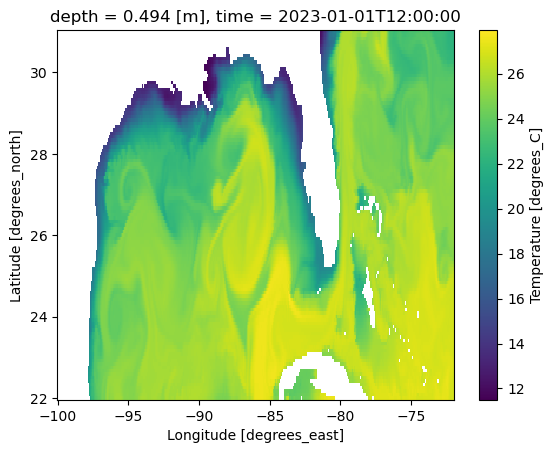

In [35]:
jan.thetao[0,0].plot()

In [22]:
ds.chunk({'depth':-1, 'latitude':-1, 'time':1, 'longitude':-1})

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, time: 304, longitude: 337)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    title:             daily mean fields from Global Ocean Physics Analysis a...
    area:              Global
    Conventions:       CF-1.8
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    ...                ...
    source:            MOI GLO12
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    institution:       Mercator Ocean International
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    comment:           
    history:           Data extracted from dataset http://localhost:8080/thre...

In [20]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [21]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.dc164bb3dbd542fea0f8ee560d2f7fe0/status,


In [25]:
#uploading 3D temp
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/3D-pottemp.zarr')
ds.chunk({'depth':-1, 'latitude':-1, 'time':1, 'longitude':-1}).to_zarr(gcsmap_ds, mode='w')

In [28]:
check = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/3D-pottemp.zarr'))

In [29]:
check

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, longitude: 337, time: 304)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.17 -72.08 -72.0
  * time       (time) datetime64[ns] 2023-01-01T12:00:00 ... 2023-10-31T12:00:00
Data variables:
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(1, 50, 109, 337), meta=np.ndarray>
Attributes: (12/13)
    Conventions:       CF-1.8
    _CoordSysBuilder:  ucar.nc2.dataset.conv.CF1Convention
    area:              Global
    comment:           
    contact:           https://marine.copernicus.eu/contact
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    ...                ...
    institution:       Mercator Ocean International
    licence:           http://marine.copernicus.eu/services-portfolio/service...
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    references:        http://marine.copernicus.eu
    source:            MOI GLO12
    title:             daily mean fields from Global Ocean Physics Analysis a...

In [15]:
! python -m pip install xgcm < 0.7.0

/bin/bash: line 1: 0.7.0: No such file or directory


In [13]:
! python -m pip install copernicus-marine-client

  Obtaining dependency information for copernicus-marine-client from https://files.pythonhosted.org/packages/3e/0f/17a0ab2148af4aa466c958fbc56e52406187bf1208fb4eab05bddc2087c6/copernicus_marine_client-0.10.4-py3-none-any.whl.metadata
  Using cached copernicus_marine_client-0.10.4-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for cachier<3.0.0,>=2.2.1 from https://files.pythonhosted.org/packages/8f/69/8caf07371931b663a0eb722d618fee5a369811693fa6ec6b03fd53299986/cachier-2.2.2-py2.py3-none-any.whl.metadata
  Using cached cachier-2.2.2-py2.py3-none-any.whl.metadata (19 kB)
  Using cached motuclient-1.8.8-py3-none-any.whl
  Obtaining dependency information for nest-asyncio<2.0.0,>=1.5.8 from https://files.pythonhosted.org/packages/0d/d0/ffa604feb4992d5ecb3a0581df1afa6f5a05027c29c49db867acd7e4e10e/nest_asyncio-1.5.9-py3-none-any.whl.metadata
  Using cached nest_asyncio-1.5.9-py3-none-any.whl.metadata (2.8 kB)
  Obtaining dependency information for semver<4.0.0,>=3.0.2 

In [16]:
import copernicus_marine_client as copernicusmarine

copernicusmarine.subset(
  dataset_id="cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m",
  variables=["thetao"],
  minimum_longitude=-100,
  maximum_longitude=-72,
  minimum_latitude=22,
  maximum_latitude=31,
  start_datetime="2023-01-01T00:00:00",
  end_datetime="2023-11-30T23:59:59",
  minimum_depth=0.49402499198913574,
  maximum_depth=0.49402499198913574,
)

username:

  sbailey2


password:

  ········


ValueError: _Service(service_name=<_ServiceName.FILES: 'original-files'>, short_name=<_ServiceShortName.FILES: 'files'>) is not a valid CopernicusMarineDatasetServiceType

In [2]:
gopaf_ds = xr.merge([xr.open_dataset(f) for f in glob.glob('/home/jovyan/MHW-WMT/GOPAF-data/*.nc')])

OSError: [Errno -101] NetCDF: HDF error: '/home/jovyan/MHW-WMT/GOPAF-data/glo12_rg_1d-m_20230125-20230125_3D-thetao_hcst_R20230208.nc'

In [1]:
pwd

'/home/jovyan/MHW-WMT'

In [12]:
! pip install xgcm<0.7.0

/bin/bash: line 1: 0.7.0: No such file or directory


In [13]:
!pip install copernicus_marine_client

In [14]:
# Import modules
import copernicus_marine_client as copernicusmarine
from pprint import pprint

In [ ]:
copernicusmarine.get()

In [15]:
catalogue = copernicusmarine.describe(contains=["001_024"], include_datasets=True)
pprint(catalogue)

ValueError: _Service(service_name=<_ServiceName.FILES: 'original-files'>, short_name=<_ServiceShortName.FILES: 'files'>) is not a valid CopernicusMarineDatasetServiceType

In [6]:
# Call the get function to save data
get_result_dailymean_2023 = copernicusmarine.get(
    dataset_id = 'cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m',
    filter = "*2023*.nc",
    no_directories = True,
    output_directory = "/home/jovyan/MHW-WMT/GOPAF-data" 
)

pprint(f"List of saved files: {get_result_dailymean_2023}")

username:

  sbailey2


password:

  ········


ValueError: _Service(service_name=<_ServiceName.FILES: 'original-files'>, short_name=<_ServiceShortName.FILES: 'files'>) is not a valid CopernicusMarineDatasetServiceType

In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_mfdataset('*.nc', chunks={})

In [3]:
ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 109, longitude: 336, time: 305)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01
Data variables:
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(90, 50, 109, 336), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(90, 50, 109, 336), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    title:             daily mean fields from Global Ocean Physics Analysis a...
    institution:       Mercator Ocean International
    producer:          CMEMS - Global Monitoring and Forecasting Centre
    source:            MOI GLO12
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           https://marine.copernicus.eu/contact
    references:        http://marine.copernicus.eu
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  GLOBAL_ANALYSISFORECAST_PHY_001_024
    subset:datasetId:  cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_202211
    subset:date:       2024-02-12T18:38:44.384Z

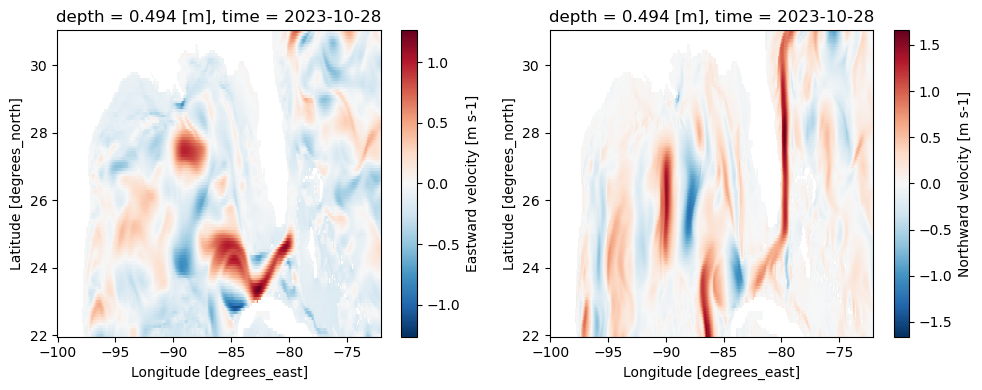

In [5]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
ds.uo[300,0].plot(ax=ax0)
ds.vo[300,0].plot(ax=ax1)
plt.tight_layout()

In [15]:
ds.uo.chunk({'time':10, 'depth':-1, 'longitude':-1, 'latitude':-1})

<xarray.DataArray 'uo' (time: 305, depth: 50, latitude: 109, longitude: 336)>
dask.array<rechunk-merge, shape=(305, 50, 109, 336), dtype=float32, chunksize=(10, 50, 109, 336), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 22.0 22.08 22.17 22.25 ... 30.83 30.92 31.0
  * longitude  (longitude) float32 -100.0 -99.92 -99.83 ... -72.25 -72.17 -72.08
  * time       (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-11-01
Attributes:
    units:          m s-1
    standard_name:  eastward_sea_water_velocity
    long_name:      Eastward velocity

In [16]:
#uploading u,v velocities
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)


gcsmap_ds = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOPAF/datasets/vels.zarr')
ds.chunk({'time':10, 'depth':-1, 'longitude':-1, 'latitude':-1}).to_zarr(gcsmap_ds, mode='w')